In [46]:
import networkx as nx
import pandas as pd
import numpy as np
import json
import cdlib
from cdlib import evaluation
from cdlib import algorithms
from cdlib import viz
from cdlib import ensemble
from cdlib import readwrite
import pickle
import pquality
import matplotlib.pyplot as plt
%matplotlib inline
from nf1 import NF1

In [2]:
path = "../DataSet StackOverflow/"

In [3]:
path_graph = "../DataSet StackOverflow/Graph_data/"

In [104]:
G = nx.read_graphml(path_graph+"Real_Network.graphml")

In [4]:
community_path = "../DataSet StackOverflow/Community_task/"

In [110]:
def scatter_plot(sizes, title):
    fig = plt.figure(figsize=(16,8), dpi= 150)
    ax = fig.add_subplot(111)

   
    labels = []
    for i in sizes:
        plt.scatter(i[0], i[1], alpha=0.5)
        labels.append(i[2])
    
    
    
    fontsize = 15
    
    #plt.yticks(ticks=y_list, labels=y_list, fontsize=fontsize, alpha=.7)
    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Size", fontsize=fontsize)
    plt.ylabel("Internal Edge Density", fontsize=fontsize)
    plt.title(title + " Scatter Plot", fontsize=fontsize)
    plt.legend(labels,fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    plt.xscale("log")
    plt.yscale("linear")
    
    #for i, v in enumerate(df[feature_2].values.tolist()):
        #ax.text(i-0.4, v+6, str(v))
    
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.6f'))
    
    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)   
    plt.show()

In [111]:
#Per plottare le communities per dimensione
def plot_communities_dimentions(coms):
    myd = {}
    for t in coms:
        lunghezza = len(t)

        if str(lunghezza) in myd:
            myd[str(lunghezza)] = myd[str(lunghezza)] + 1
        else:
            myd[str(lunghezza)] = 1

    print(myd)
    plt.figure(figsize=(20,5))
    plt.bar(myd.keys(), myd.values(), color='b')

In [112]:
def print_bold_str(s):
    return "\033[1m" + s + "\033[0m"

# 1 - Louvain
Parametri ottimizzati con grid_search

In [119]:
res_df = {"randomize": [], "resolution":[], "AID": [], "IED": [], "Conductance":[], "Modularity": [], "N_Community": [], "Max_Dim_Community": []}

In [120]:
for j in [True, False]:
    for i in [x/10 for x in range(0, 10)]:   
        print(f"> Louvain opt for resolution = {i} and randomize = {j}")
        
        res_df["randomize"].append(j)
        res_df["resolution"].append(i)
        
        louvain_coms = cdlib.algorithms.louvain(G, weight = "Count", resolution=i, randomize=j)
        res_df["AID"].append(louvain_coms.average_internal_degree().score)
        res_df["IED"].append(louvain_coms.internal_edge_density().score)
        res_df["Conductance"].append(louvain_coms.conductance().score)
        res_df["Modularity"].append(louvain_coms.newman_girvan_modularity().score)
        res_df["N_Community"].append(len(louvain_coms.communities))
        max_com_len = 0
        for com in louvain_coms.communities:
            if len(com) > max_com_len:
                max_com_len = len(com)
        res_df["Max_Dim_Community"].append(max_com_len)
        
        print("************ ------------------ *******")
final_df = pd.DataFrame(res_df)
final_df.to_csv(community_path+"louvain_grid_result.csv", index=False)

> Louvain opt for resolution = 0.0 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.1 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.2 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.3 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.4 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.5 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.6 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.7 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.8 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.9 and randomize = True
************ ------------------ *******
> Louvain opt for resolution = 0.0 and r

In [126]:
final_df = pd.read_csv(community_path+"louvain_grid_result.csv")

In [127]:
final_df.loc[[1, 2, 3, 4, 5, 6, 7, 8, 9]]

randomize  resolution       AID       IED  Conductance  Modularity  \
1       True         0.1  3.509341  0.270649     0.563301    0.336063   
2       True         0.2  3.694126  0.358289     0.463214    0.386592   
3       True         0.3  3.744057  0.418430     0.378586    0.411670   
4       True         0.4  3.614078  0.494615     0.296042    0.435541   
5       True         0.5  3.572232  0.533579     0.272630    0.445083   
6       True         0.6  3.487365  0.567484     0.233576    0.455591   
7       True         0.7  3.308322  0.613688     0.197025    0.467442   
8       True         0.8  3.274966  0.652699     0.165962    0.468484   
9       True         0.9  3.256247  0.651260     0.151376    0.470043   

   N_Community  Max_Dim_Community  
1          216                412  
2          119                685  
3           90                801  
4           71               1207  
5           68               1524  
6           61               1732  
7           57               2027  
8           53               2106  
9           51               2193

Ottimizzazione con randomsearch

In [123]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
parameters = [resolution]

In [124]:
louvain_coms, scoring = ensemble.grid_search(graph=G, method=algorithms.louvain,
                                                       parameters=parameters,
                                                       quality_score=evaluation.newman_girvan_modularity, aggregate=max)

In [125]:
print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(louvain_coms.communities, louvain_coms.method_parameters, scoring))

Communities:
 [['ios', 'xcode', 'firebase', 'google-cloud-firestore', 'android', 'android-studio', 'macos', 'react-native', 'cocoapods', 'firebase-cloud-messaging', 'react-navigation-drawer', 'swift', 'swiftui', 'apple-m1', 'react-native-android', 'firebase-storage', 'google-maps', 'plugins', 'macos-big-sur', 'youtube', 'google-play', 'deprecated', 'gradle', 'android-app-bundle', 'firebase-authentication', 'react-native-ios', 'react-native-navigation', 'mobile', 'apk', 'google-maps-api-3', 'google-calendar-api', 'native-base', 'expo', 'assets', 'android-toolbar', 'sdk', 'firebase-analytics', 'drop-down-menu', 'watchkit', 'react-navigation', 'xamarin', 'http-proxy', 'denial-of-service', 'location', 'navigation-drawer', 'storage', 'keyboard', 'textfield', 'fastlane', 'material-design', 'debounce', 'webview', 'image', 'state', 'spotify', 'user-interface', 'lint', 'react-navigation-stack', 'facebook', 'react-native-firebase', 'google-authentication', 'animation', 'flipper', 'detox', 'setst

In [48]:
louvain_coms = cdlib.algorithms.louvain(G, weight = "Count", resolution=0.9)

In [49]:
with open(community_path+'louvain.pickle', 'wb') as f:
    pickle.dump(louvain_coms, f)

In [128]:
print(print_bold_str("Average Internal Degree:"), louvain_coms.average_internal_degree())
print(print_bold_str("Internal Edge Density:"), louvain_coms.internal_edge_density())
print(print_bold_str("Conductance:"), louvain_coms.conductance())
print(print_bold_str("Erdos Renyi Modularity:"), louvain_coms.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), louvain_coms.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), louvain_coms.modularity_density())
print(print_bold_str("Z Modularity:"), louvain_coms.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), louvain_coms.triangle_participation_ratio())

print(print_bold_str("N_Community:"), len(louvain_coms.communities))

max_com_len = 0
for com in louvain_coms.communities:
    if len(com) > max_com_len:
        max_com_len = len(com)
print(print_bold_str("Max_Dim_Community:"), max_com_len)    

Average Internal Degree: FitnessResult(min=1.0, max=10.827328029948527, score=3.123352117623514, std=2.8802412206650256)
Internal Edge Density: FitnessResult(min=0.004073135939593343, max=1.0, score=0.7002699850140246, std=0.42694031593577353)
Conductance: FitnessResult(min=0.0, max=0.5563786008230452, score=0.1268912005650071, std=0.20183441702432564)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.4868935022501819, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.4763787054827605, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=69.02843546585075, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=1.4355297536629263, std=None)
Triangle Partecipation Ratio: FitnessResult(min=0.0, max=1.0, score=0.4786476876373557, std=0.461122090298045)
N_Community: 44
Max_Dim_Community: 2263


In [50]:
louvain_tuple = [tuple(x) for x in louvain_coms.communities]

{'2219': 1, '1850': 1, '1528': 1, '1514': 1, '1234': 1, '1208': 1, '1144': 1, '914': 1, '762': 1, '484': 1, '437': 1, '225': 1, '138': 1, '14': 1, '10': 1, '9': 1, '5': 3, '4': 5, '3': 5, '2': 20}


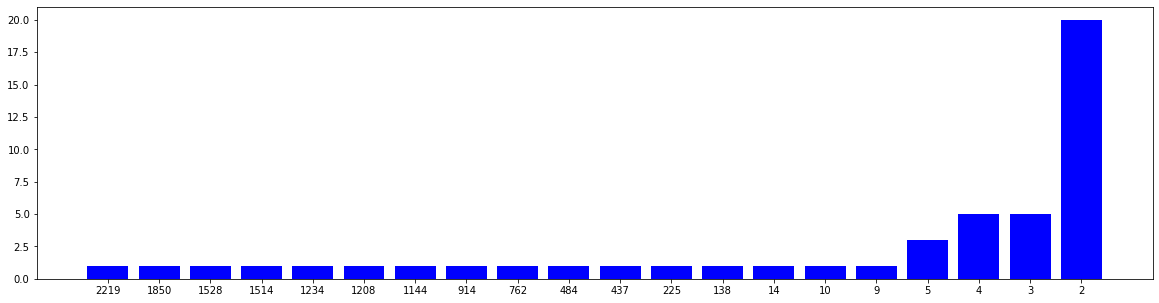

In [51]:
# Analizziamo la cardinalità delle communities
plot_communities_dimentions(louvain_tuple)

In [52]:
results = pquality.pquality_summary(G, louvain_tuple)
results['Indexes']

min           max          avg          std
Index                                                             
Internal Density  0.004698      1.000000     0.668171     0.432416
Edges inside      1.000000  11561.000000  1161.795918  2570.598263
Average Degree    1.000000     10.420009     3.209995     2.760784
FOMD              0.000000      0.500000     0.156555     0.195150
TPR               0.000000      1.000000     0.523559     0.457089
Expansion         0.000000      6.707398     1.644610     2.534881
Cut Ratio         0.000000      0.000554     0.000129     0.000201
Conductance       0.000000      0.530239     0.144598     0.200958
Normalized Cut    0.000000      0.546306     0.153317     0.213490
Maximum-ODF       0.000000   1331.000000   161.326531   331.405565
Average-ODF       0.000000      6.707398     1.644610     2.534881
Flake-ODF         0.000000      0.280000     0.050284     0.080668

In [53]:
results['Modularity']

value
Index                            
Modularity (no overlap)  0.468137

# 2 - Label Propagation

In [130]:
labelprop_coms = algorithms.label_propagation(G)

In [135]:
print(print_bold_str("Average Internal Degree:"), labelprop_coms.average_internal_degree())
print(print_bold_str("Internal Edge Density:"), labelprop_coms.internal_edge_density())
print(print_bold_str("Conductance:"), labelprop_coms.conductance())
print(print_bold_str("Erdos Renyi Modularity:"), labelprop_coms.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), labelprop_coms.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), labelprop_coms.modularity_density())
print(print_bold_str("Z Modularity:"), labelprop_coms.z_modularity())
print(print_bold_str("Triangle Partecipation Ratio:"), labelprop_coms.triangle_participation_ratio())

print(print_bold_str("N_Community:"), len(labelprop_coms.communities))

max_com_len = 0
for com in labelprop_coms.communities:
    if len(com) > max_com_len:
        max_com_len = len(com)
print(print_bold_str("Max_Dim_Community:"), max_com_len)        

Average Internal Degree: FitnessResult(min=1.0, max=14.624197083049951, score=1.6820400294275446, std=1.2376468892121288)
Internal Edge Density: FitnessResult(min=0.0011052144107504497, max=1.0, score=0.9343306261567194, std=0.1714446000623619)
Conductance: FitnessResult(min=0.0, max=0.6, score=0.36814935167560386, std=0.18803732065076517)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.07175182880675159, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.010979009591406054, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=126.00077845402036, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=0.0848402035613818, std=None)
Triangle Partecipation Ratio: FitnessResult(min=0.0, max=1.0, score=0.4099655356861411, std=0.4759401344727783)
N_Community: 188
Max_Dim_Community: 13233


In [136]:
with open(community_path+'labelprop.pickle', 'wb') as f:
    pickle.dump(labelprop_coms, f)

In [137]:
labelprop_tuple = [tuple(x) for x in labelprop_coms.communities]

{'13233': 1, '13': 1, '9': 2, '8': 3, '7': 3, '6': 1, '5': 8, '4': 20, '3': 47, '2': 102}


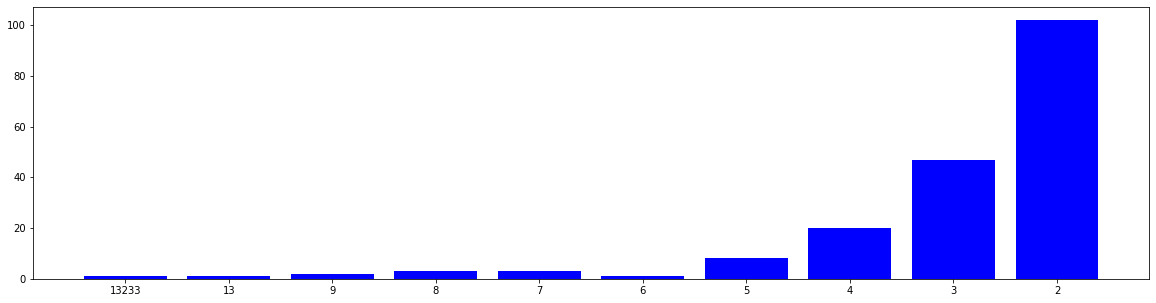

In [140]:
plot_communities_dimentions(labelprop_tuple)

In [141]:
results = pquality.pquality_summary(G, labelprop_tuple)
results['Indexes']

min           max         avg          std
Index                                                            
Internal Density  0.001105      1.000000    0.934331     0.171445
Edges inside      1.000000  96761.000000  517.547872  7038.019027
Average Degree    1.000000     14.624197    1.682040     1.237647
FOMD              0.000000      0.461538    0.039769     0.106910
TPR               0.000000      1.000000    0.409966     0.475940
Expansion         0.000000      2.250000    1.011823     0.604036
Cut Ratio         0.000000      0.000163    0.000074     0.000044
Conductance       0.000000      0.600000    0.368149     0.188037
Normalized Cut    0.000000      0.600015    0.369262     0.186505
Maximum-ODF       0.000000     27.000000    1.515957     2.267898
Average-ODF       0.000000      2.250000    1.011823     0.604036
Flake-ODF         0.000000      0.500000    0.004388     0.040080

In [142]:
results['Modularity']

value
Index                            
Modularity (no overlap)  0.010979

# 3 - Demon
Parametri ottimizzati con grid_search

In [133]:
eps = ensemble.Parameter(name="epsilon", start=0.1, end=0.6, step=0.1)
size = ensemble.Parameter(name="min_com_size", start=3, end=5,step=1)

In [134]:
coms_demon, scoring = ensemble.random_search(graph=G, method=algorithms.demon,
                                                       parameters=[eps, size],
                                                       quality_score=evaluation.newman_girvan_modularity,
                                                        aggregate=max)

print("Communities:\n %s \nConfiguration: %s \nScoring: %s" %(coms_demon.communities, coms_demon.method_parameters, scoring))

Communities:
 [['.class-file', '.htaccess', '.net', '.net-2.0', '.net-4.0', '.net-4.5', '.net-4.6.1', '.net-4.7.2', '.net-4.8', '.net-5', '.net-assembly', '.net-attributes', '.net-core', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-publishsinglefile', '.net-core-sdk', '.net-core-service-worker', '.net-framework-4.8', '.net-framework-version', '.net-standard', '.net-standard-2.0', '.npmrc', '.so', '1password', '2-way-object-databinding', '24-bit', '2d', '2phase-commit', '32bit-64bit', '3d', '3d-reconstruction', '64-bit', '7zip', 'aapt', 'aar', 'abap', 'abc', 'abi', 'abp', 'absinthe', 'absinthe-subscription', 'absolute', 'abstract', 'abstract-algebra', 'abstract-class', 'abstract-methods', 'abstract-syntax-tree', 'abstraction', 'access-keys', 'access-modifiers', 'access-token', 'access-violation', 'accessibility', 'accessor', 'accessory', 'accordion', 'accounting', 'accumulate', 'ace-editor', 'acfpro', 'acme.sh', 'acorn', 'across', 'act', 'action', 'action-filter', 'acti

In [145]:
print(print_bold_str("Average Internal Degree:"), coms_demon.average_internal_degree())
print(print_bold_str("Internal Edge Density:"), coms_demon.internal_edge_density())
print(print_bold_str("Conductance:"), coms_demon.conductance())
print(print_bold_str("Erdos Renyi Modularity:"), coms_demon.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), coms_demon.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), coms_demon.modularity_density())
print(print_bold_str("Z Modularity:"), coms_demon.z_modularity())


Average Internal Degree: FitnessResult(min=2.5, max=25.586301369863012, score=10.195133674265012, std=8.6100273051793)
Internal Edge Density: FitnessResult(min=0.002202256695383706, max=1.0, score=0.5377058059507719, std=0.45350104174008715)
Conductance: FitnessResult(min=0.0, max=0.9957035445757251, score=0.61474557704103, std=0.3159109607845711)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=6.955557871255676, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.08835531457961601, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=-4864.6986651692205, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=nan, std=None)


In [146]:
print(print_bold_str("N_Community:"), len(coms_demon.communities))

max_com_len = 0
for com in coms_demon.communities:
    if len(com) > max_com_len:
        max_com_len = len(com)
print(print_bold_str("Max_Dim_Community:"), max_com_len)        

N_Community: 73
Max_Dim_Community: 8445


In [147]:
with open(community_path+'demon.pickle', 'wb') as f:
    pickle.dump(coms_demon, f)

In [148]:
demon_tuple = [tuple(x) for x in coms_demon.communities]

In [149]:
print("Numero di communities: ", len(demon_tuple))

Numero di communities:  73


{'8445': 1, '7352': 1, '6557': 1, '6188': 1, '5754': 1, '5400': 1, '4758': 1, '4473': 1, '4144': 1, '3921': 1, '3274': 1, '2916': 1, '2287': 1, '2233': 1, '2190': 1, '1897': 1, '1653': 1, '1571': 1, '1334': 1, '799': 1, '618': 1, '477': 1, '437': 1, '407': 1, '397': 1, '317': 1, '190': 1, '93': 1, '89': 1, '67': 1, '43': 1, '14': 1, '11': 1, '10': 1, '8': 1, '7': 2, '6': 2, '5': 13, '4': 21}


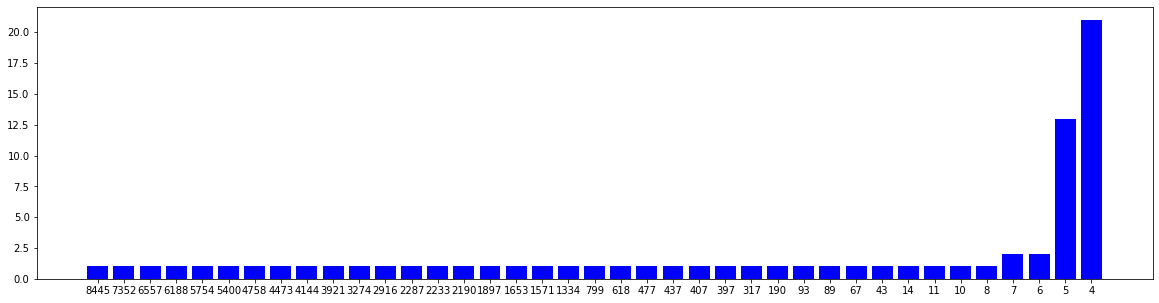

In [150]:
plot_communities_dimentions(demon_tuple)

In [151]:
results = pquality.pquality_summary(G, demon_tuple)
results['Indexes']

min           max           avg           std
Index                                                               
Internal Density  0.002202      1.000000      0.537706      0.453501
Edges inside      5.000000  78521.000000  12087.136986  21862.749106
Average Degree    2.500000     25.586301     10.195134      8.610027
FOMD              0.000000      0.500000      0.257287      0.227321
TPR               1.000000      1.000000      1.000000      0.000000
Expansion         0.000000    695.250000     76.834841    149.523896
Cut Ratio         0.000000      0.050468      0.005671      0.010823
Conductance       0.000000      0.995704      0.614746      0.315911
Normalized Cut    0.000000      1.009710      0.704459      0.282065
Maximum-ODF       0.000000   2781.000000   1011.000000    977.410739
Average-ODF       0.000000    695.250000     76.834841    149.523896
Flake-ODF         0.000000      0.750000      0.235480      0.185749

In [152]:
results['Modularity']

value
Index                            
Modularity (no overlap)  0.088355

# 4 - GM

In [22]:
GM_coms = algorithms.greedy_modularity(G, weight = "Count") 

In [23]:
print(print_bold_str("Average Internal Degree:"), GM_coms.average_internal_degree())
print(print_bold_str("Internal Edge Density:"), GM_coms.internal_edge_density())
print(print_bold_str("Conductance:"), GM_coms.conductance())
print(print_bold_str("Erdos Renyi Modularity:"), GM_coms.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), GM_coms.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), GM_coms.modularity_density())
print(print_bold_str("Z Modularity:"), GM_coms.z_modularity())

Average Internal Degree: FitnessResult(min=1.0, max=8.883227176220807, score=3.0354813842784174, std=1.7419481893650166)
Internal Edge Density: FitnessResult(min=0.008346103638117941, max=1.0, score=0.33311052812742353, std=0.4231542309016087)
Conductance: FitnessResult(min=0.0, max=0.925503355704698, score=0.5160243055427404, std=0.3525906896097731)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.3570753585311342, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=0.35680380478760504, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=-513.5786324553409, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=1.972108505073173, std=None)


In [24]:
print(print_bold_str("N_Community:"), len(GM_coms.communities))

max_com_len = 0
for com in GM_coms.communities:
    if len(com) > max_com_len:
        max_com_len = len(com)
print(print_bold_str("Max_Dim_Community:"), max_com_len)   

N_Community: 108
Max_Dim_Community: 942


In [25]:
with open(community_path+'GM.pickle', 'wb') as f:
    pickle.dump(GM_coms, f)

In [26]:
GM_tuple = [tuple(x) for x in GM_coms.communities]

{'942': 1, '840': 1, '803': 1, '754': 1, '689': 1, '669': 1, '640': 1, '626': 1, '503': 1, '478': 1, '462': 1, '391': 1, '388': 1, '348': 1, '342': 1, '286': 1, '265': 1, '243': 1, '209': 1, '178': 1, '173': 1, '166': 2, '165': 1, '136': 1, '133': 1, '126': 1, '124': 1, '113': 1, '104': 1, '99': 1, '93': 1, '90': 1, '86': 2, '84': 1, '83': 1, '80': 1, '78': 1, '77': 1, '75': 1, '70': 1, '68': 2, '65': 1, '56': 1, '53': 1, '52': 1, '51': 1, '50': 2, '49': 1, '48': 1, '47': 1, '44': 2, '42': 1, '39': 1, '35': 1, '33': 1, '31': 2, '30': 3, '29': 2, '26': 1, '24': 1, '23': 1, '18': 1, '13': 1, '9': 1, '5': 5, '4': 5, '3': 5, '2': 20}


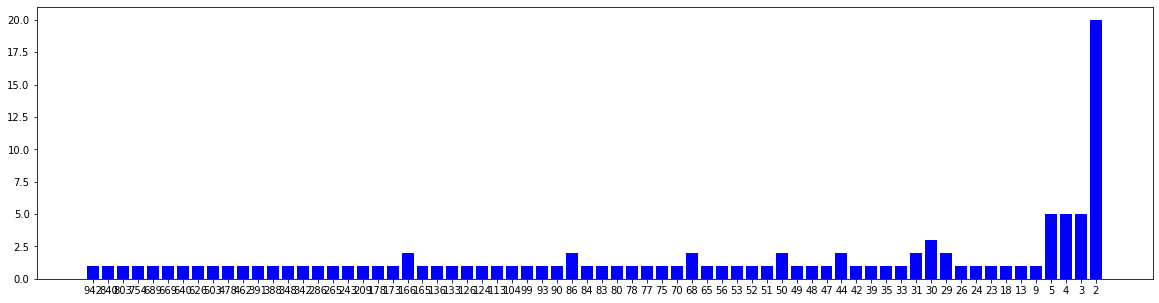

In [27]:
plot_communities_dimentions(GM_tuple)

In [28]:
results = pquality.pquality_summary(G, GM_tuple)
results['Indexes']

min          max         avg         std
Index                                                          
Internal Density  0.008346     1.000000    0.333111    0.423154
Edges inside      1.000000  4184.000000  354.120370  743.758657
Average Degree    1.000000     8.883227    3.035481    1.741948
FOMD              0.000000     0.500000    0.267843    0.179886
TPR               0.000000     1.000000    0.511117    0.338431
Expansion         0.000000    32.069767    7.790839    6.354331
Cut Ratio         0.000000     0.002342    0.000571    0.000463
Conductance       0.000000     0.925503    0.516024    0.352591
Normalized Cut    0.000000     0.939410    0.521648    0.354670
Maximum-ODF       0.000000  2699.000000  305.240741  422.590531
Average-ODF       0.000000    32.069767    7.790839    6.354331
Flake-ODF         0.000000     1.000000    0.346820    0.286017

In [29]:
results['Modularity']

value
Index                            
Modularity (no overlap)  0.356804

# 5 -  CONFRONTI
1) Lettura

In [5]:
with open(community_path+'louvain.pickle', 'rb') as f:
    louvain_coms = pickle.load(f)
with open(community_path+'labelprop.pickle', 'rb') as f:
    labelprop_coms = pickle.load(f)
with open(community_path+'demon.pickle', 'rb') as f:
    demon_coms = pickle.load(f)
with open(community_path+'GM.pickle', 'rb') as f:
    GM_coms = pickle.load(f)

In [118]:
def covg_overlap(G, community, name):
    print(f'{name} coverage:', community.node_coverage)
    print(f'{name} overlap:', community.overlap) 
    print(f'{name} avg degree:', evaluation.average_internal_degree(G, community))
    print("*******")

In [12]:
covg_overlap(G, louvain_coms, "Louvain")
covg_overlap(G, labelprop_coms, "LabelPropagation")
covg_overlap(G, demon_coms, "Demon")
covg_overlap(G, GM_coms, "GM")

Louvain coverage: 1.0
Louvain overlap: False
Louvain avg degree: FitnessResult(min=1.0, max=10.42000901306895, score=3.2099946721269212, std=2.7607837446394896)
*******
LabelPropagation coverage: 1.0
LabelPropagation overlap: False
LabelPropagation avg degree: FitnessResult(min=1.0, max=14.624197083049951, score=1.6820400294275446, std=1.2376468892121288)
*******
Demon coverage: 0.9389695210449928
Demon overlap: True
Demon avg degree: FitnessResult(min=2.5, max=25.586301369863012, score=10.195133674265012, std=8.6100273051793)
*******
GM coverage: 1.0
GM overlap: False
GM avg degree: FitnessResult(min=1.0, max=8.883227176220807, score=3.0354813842784174, std=1.7419481893650166)
*******


2) Confronti

2.1) Size BoxPlot

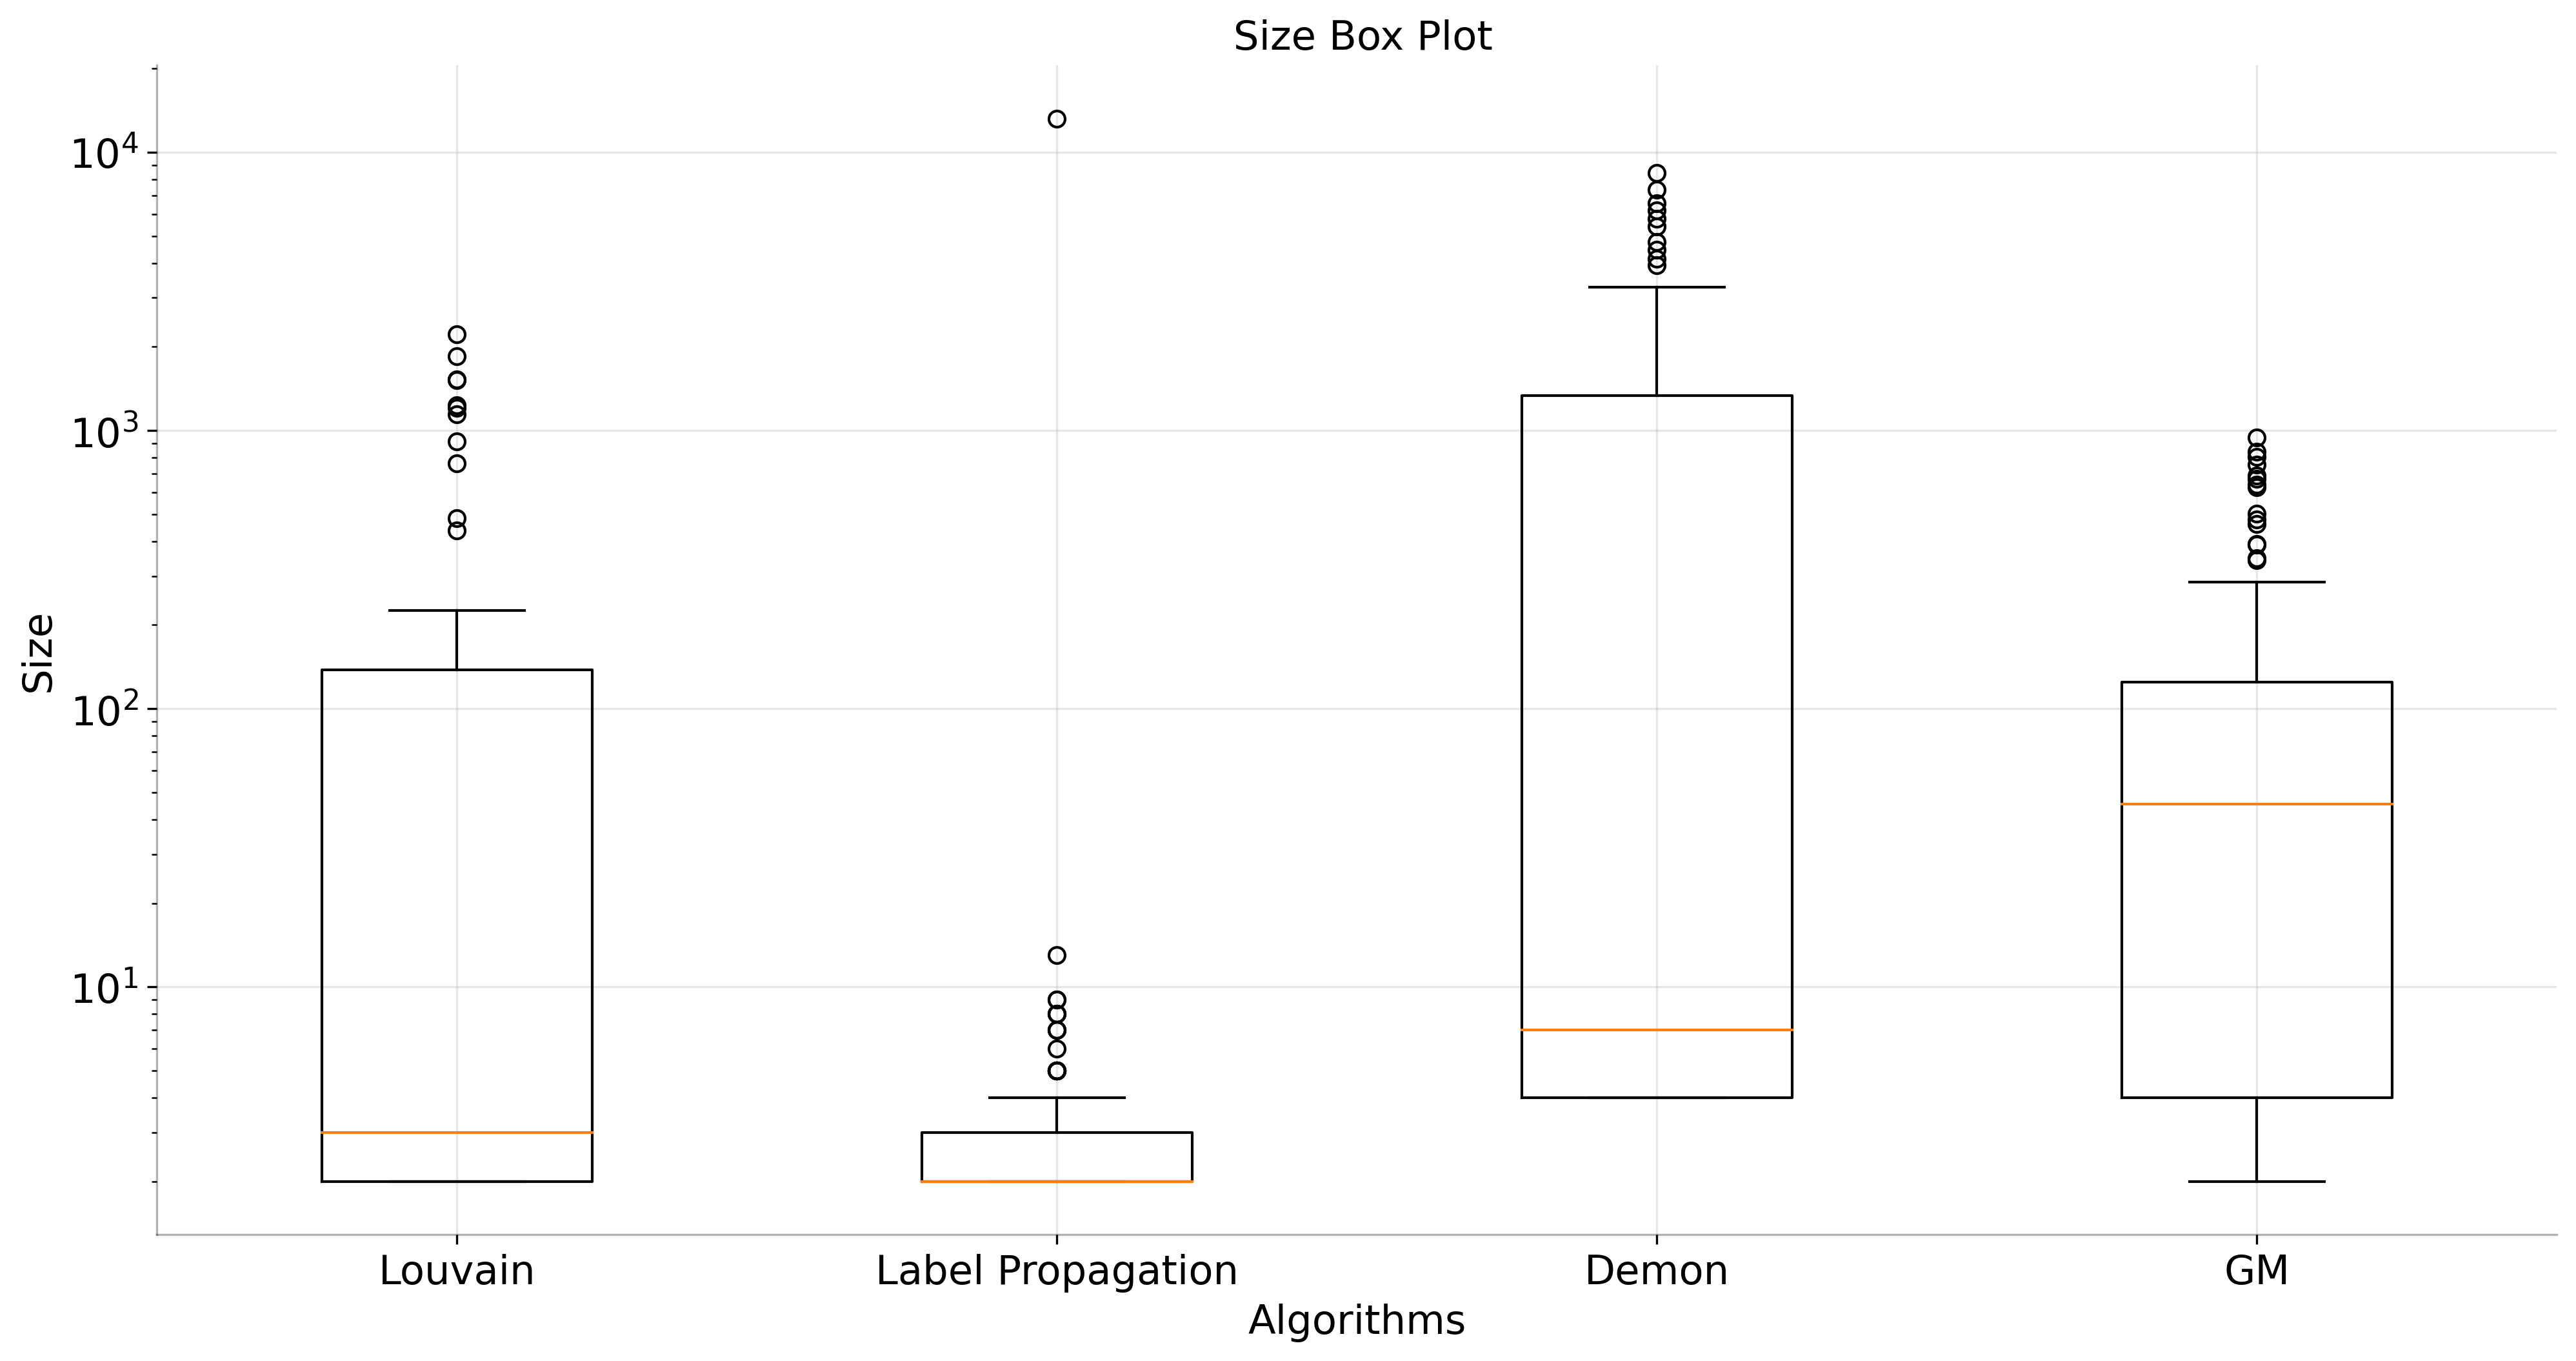

In [66]:
plot_list = [ np.array(evaluation.size(G,louvain_coms, summary=False)), 
             np.array(evaluation.size(G,labelprop_coms, summary=False)),
             np.array(evaluation.size(G,demon_coms, summary=False)),
             np.array(evaluation.size(G,GM_coms, summary=False))]
labels = ["Louvain", "Label Propagation", "Demon", "GM"]

fig = plt.figure(figsize=(16,8), dpi= 300)
ax = fig.add_subplot(111)
plt.boxplot(plot_list,labels=labels)
#plt.boxplot(x)

fontsize = 15

#plt.yticks(ticks=y_list, labels=y_list, fontsize=fontsize, alpha=.7)
plt.yticks(fontsize=fontsize, alpha=1)
plt.xticks(fontsize=fontsize, alpha=1)
plt.xlabel('Algorithms', fontsize=fontsize)
plt.ylabel("Size", fontsize=fontsize)
plt.title(" Size Box Plot", fontsize=fontsize)
#plt.title(name + " in 24 hours", fontsize=fontsize)
plt.grid(axis='both', alpha=.3)
plt.yscale("log")



# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

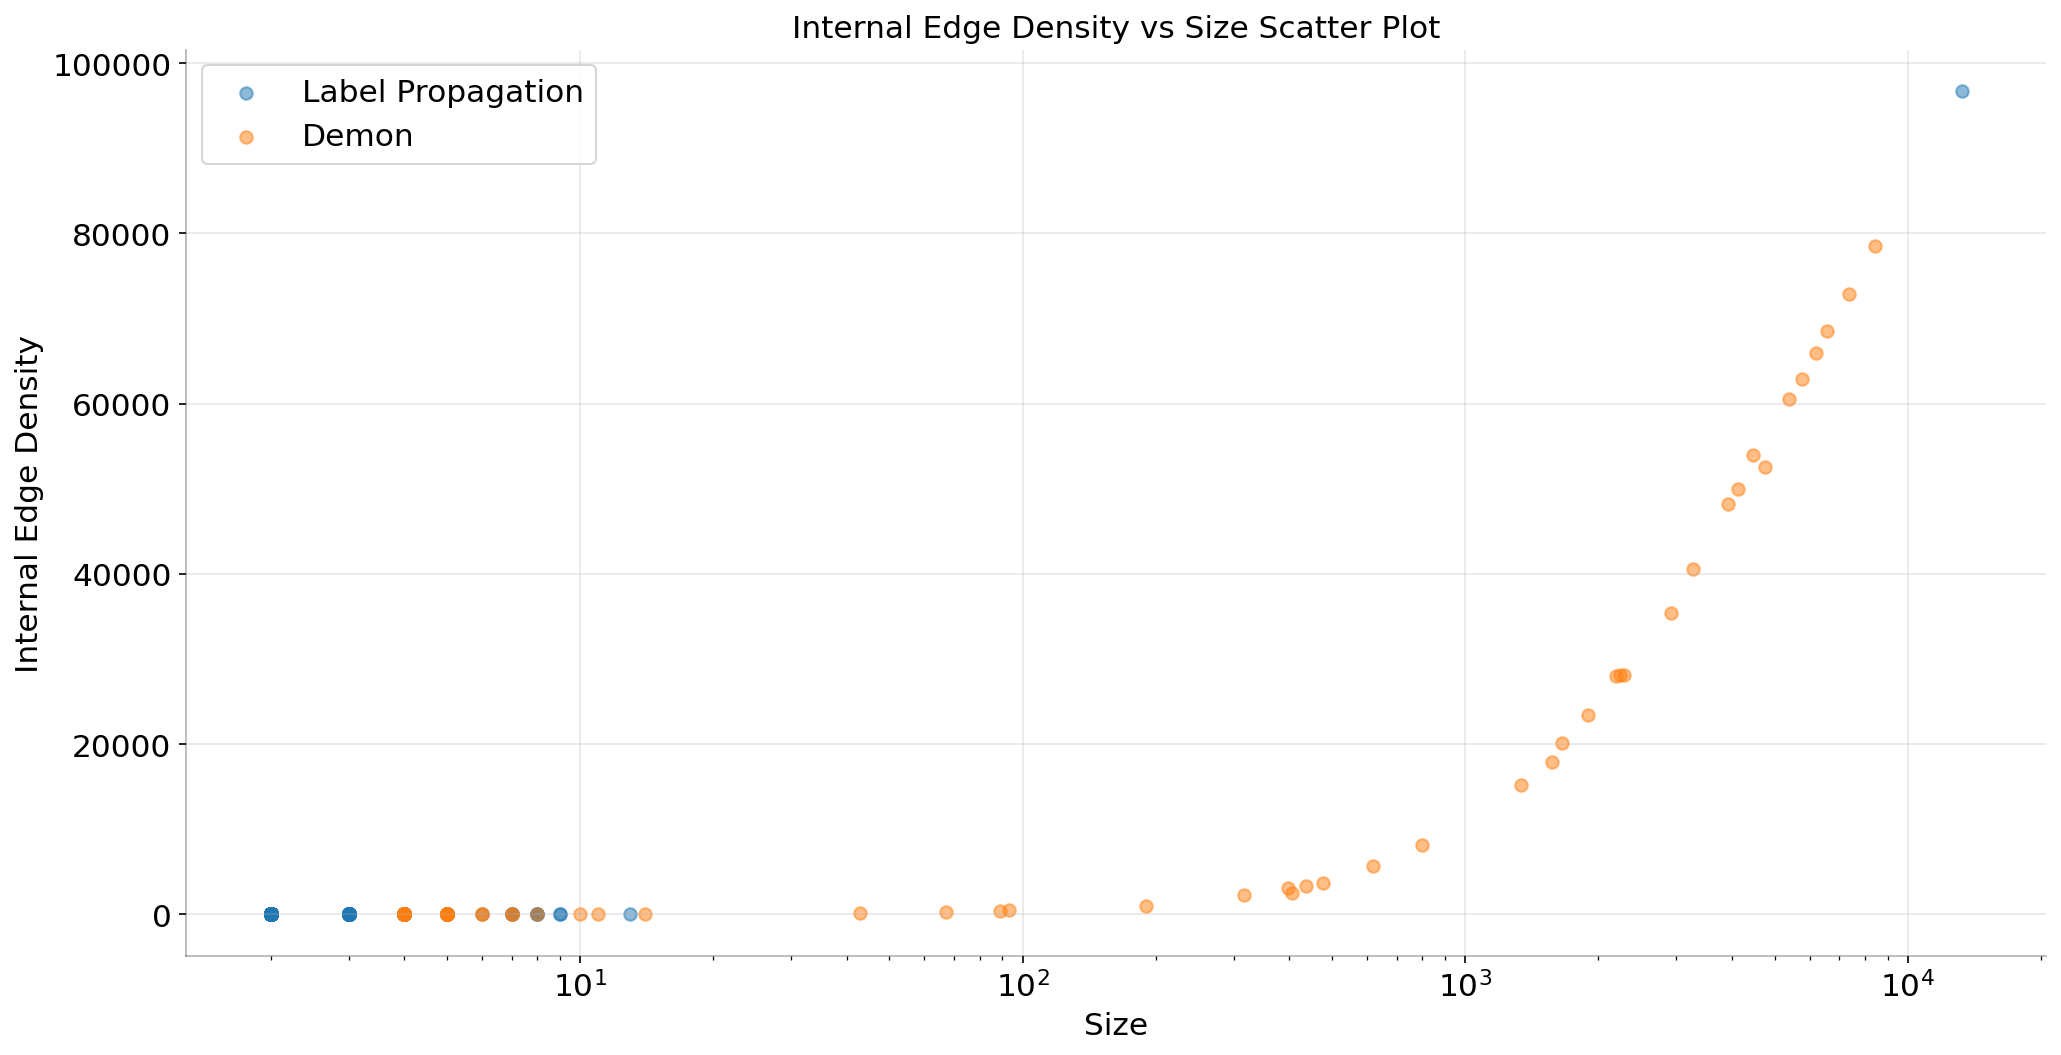

In [68]:
edge_density_ = [(np.array(evaluation.size(G,labelprop_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,labelprop_coms, summary=False)),
                               "Label Propagation"),
                               (np.array(evaluation.size(G,demon_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,demon_coms, summary=False)),
                                "Demon")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

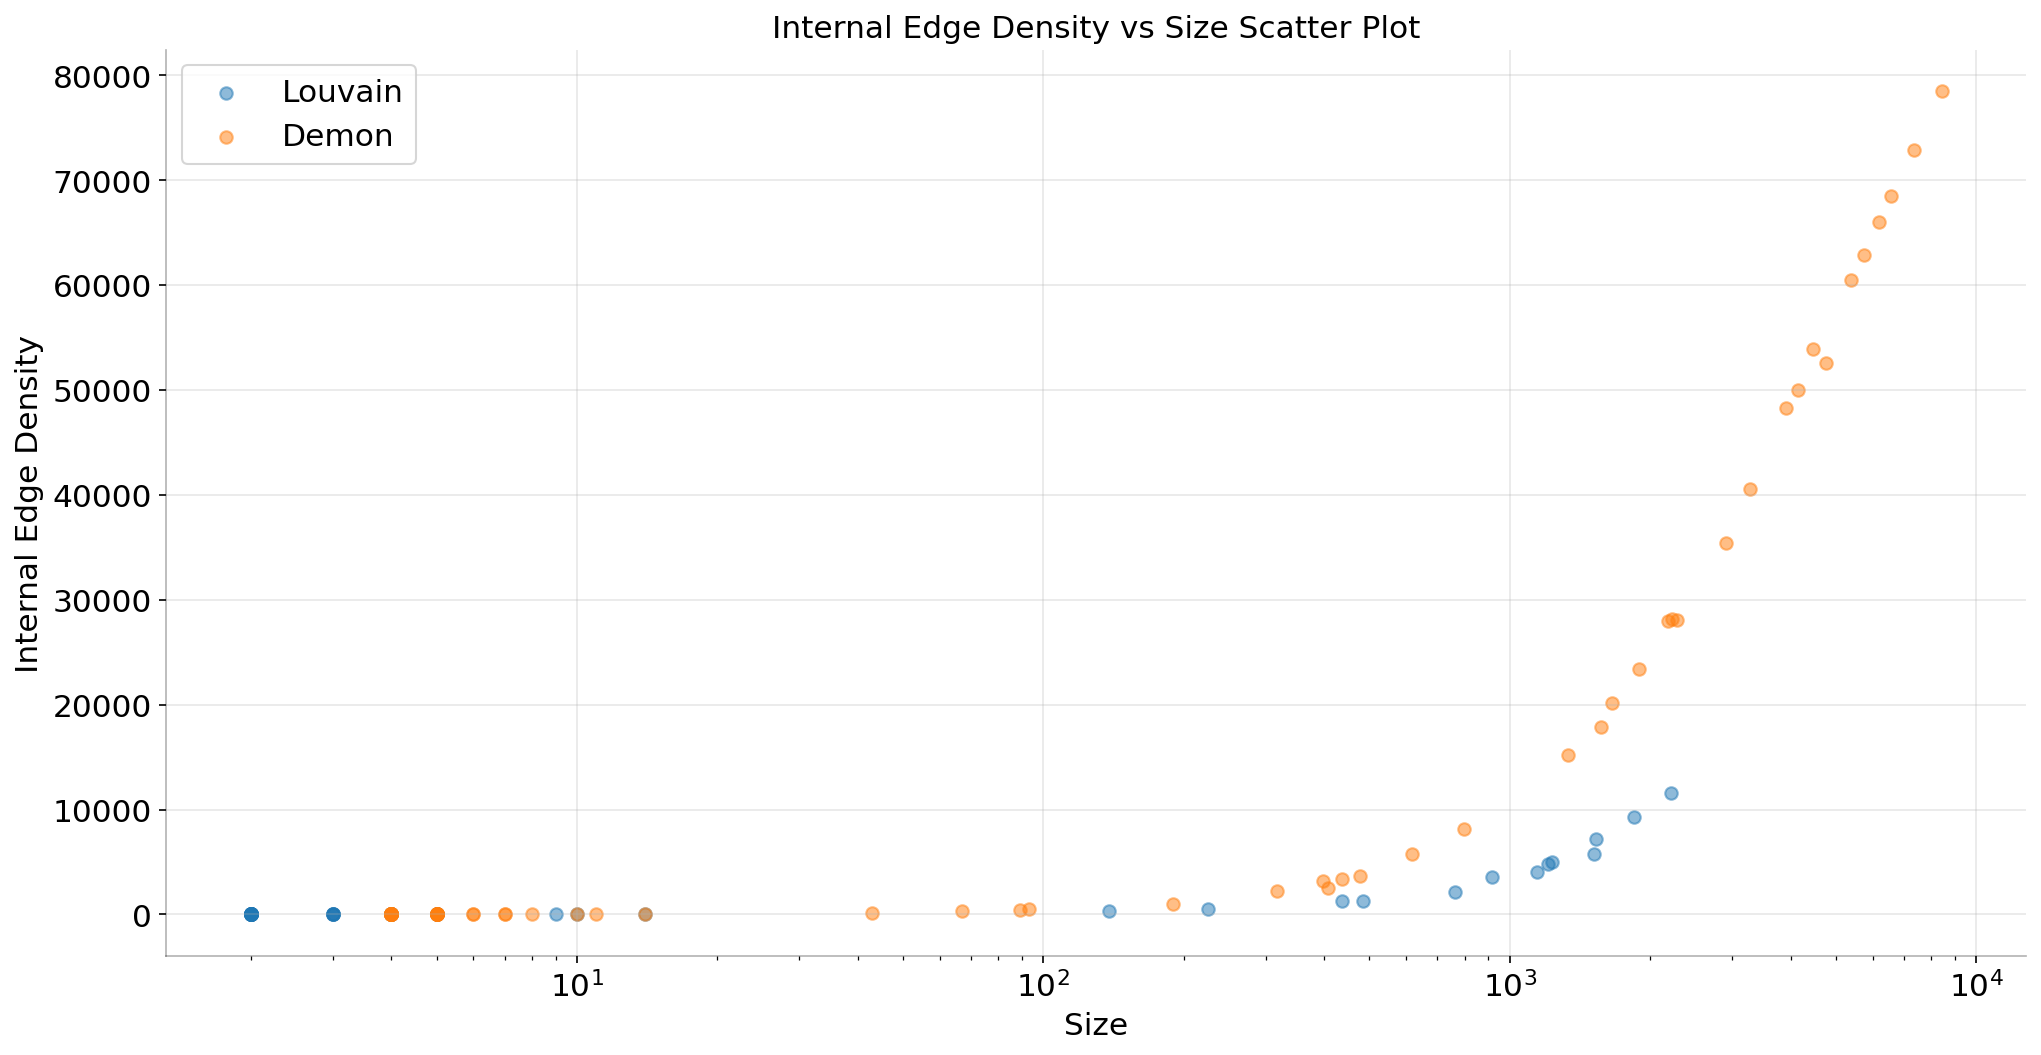

In [69]:
edge_density_= [(np.array(evaluation.size(G,louvain_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,louvain_coms, summary=False)),
                               "Louvain"),
                               (np.array(evaluation.size(G,demon_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,demon_coms, summary=False)),
                                "Demon")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

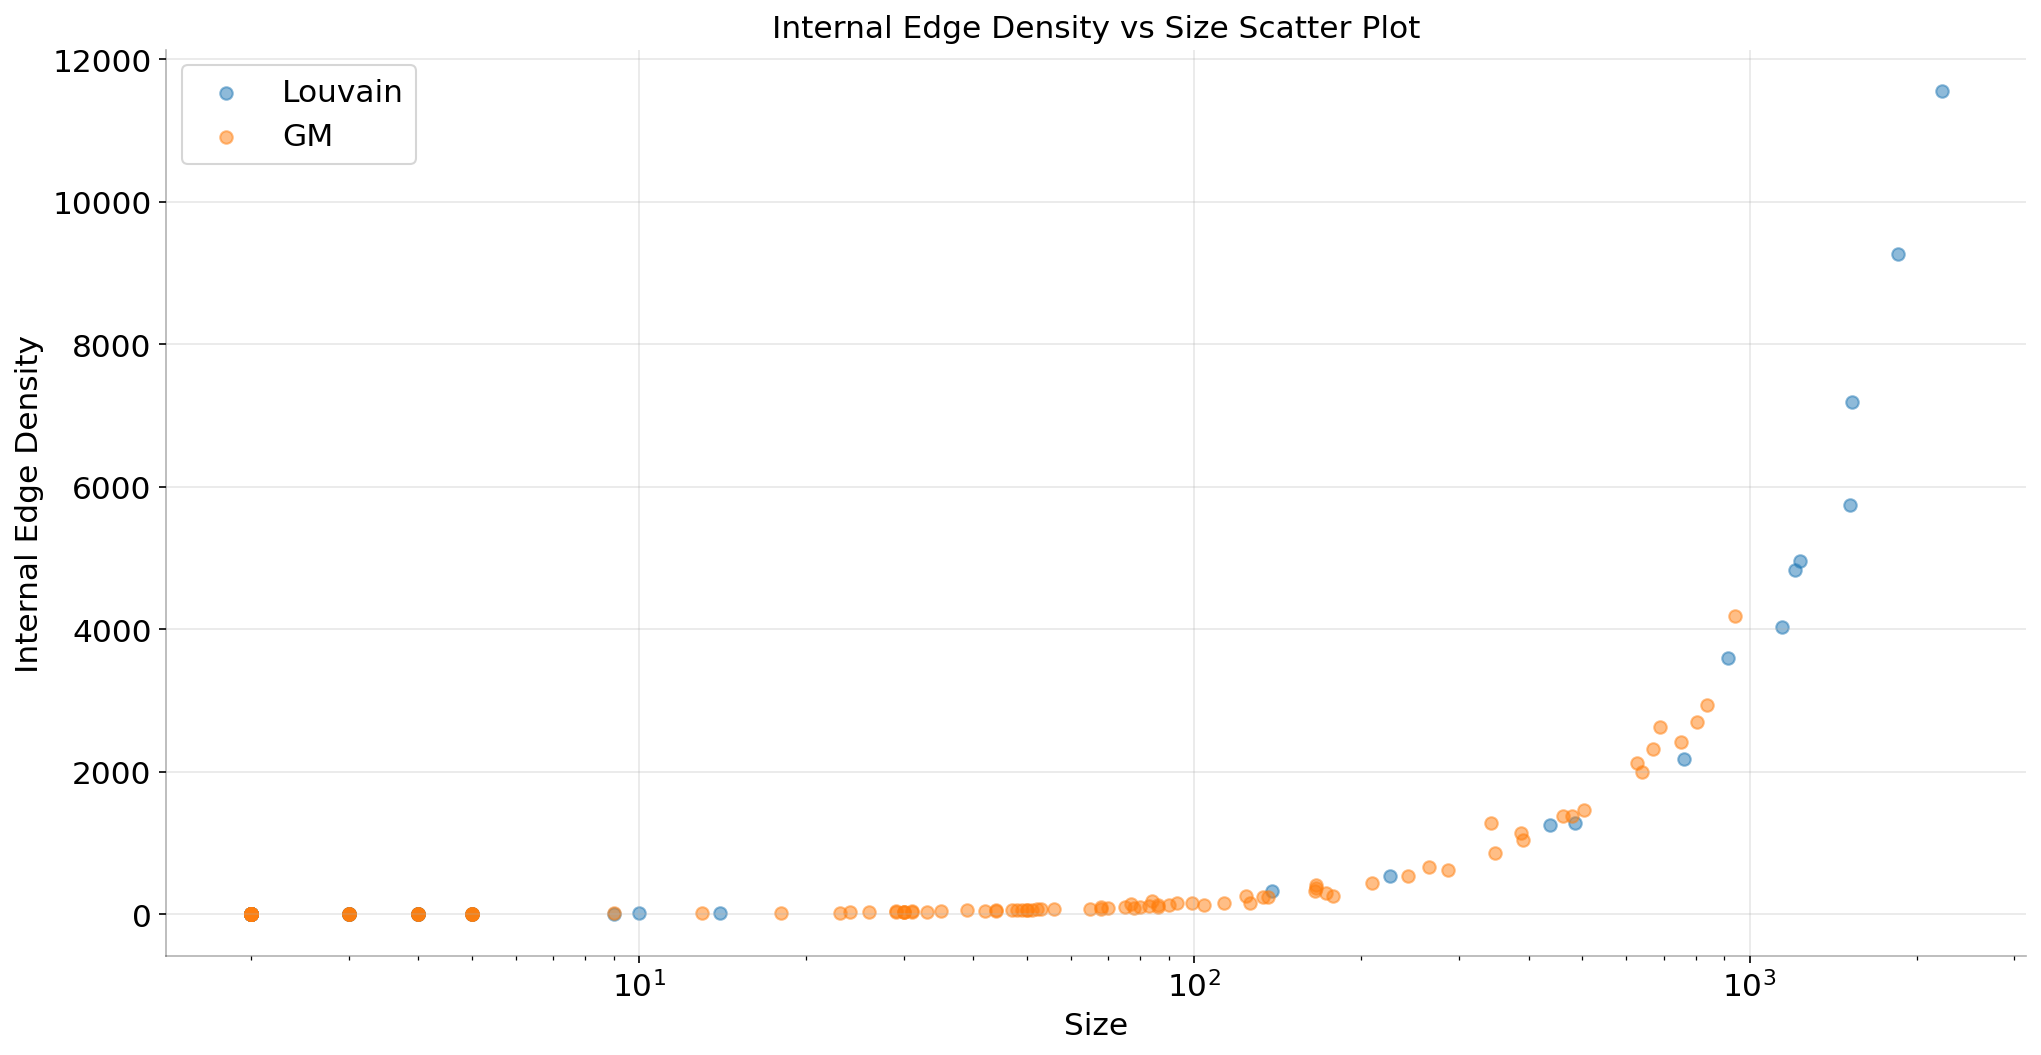

In [70]:
edge_density_= [(np.array(evaluation.size(G,louvain_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,louvain_coms, summary=False)),
                               "Louvain"),
                               (np.array(evaluation.size(G,GM_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,GM_coms, summary=False)),
                                "GM")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

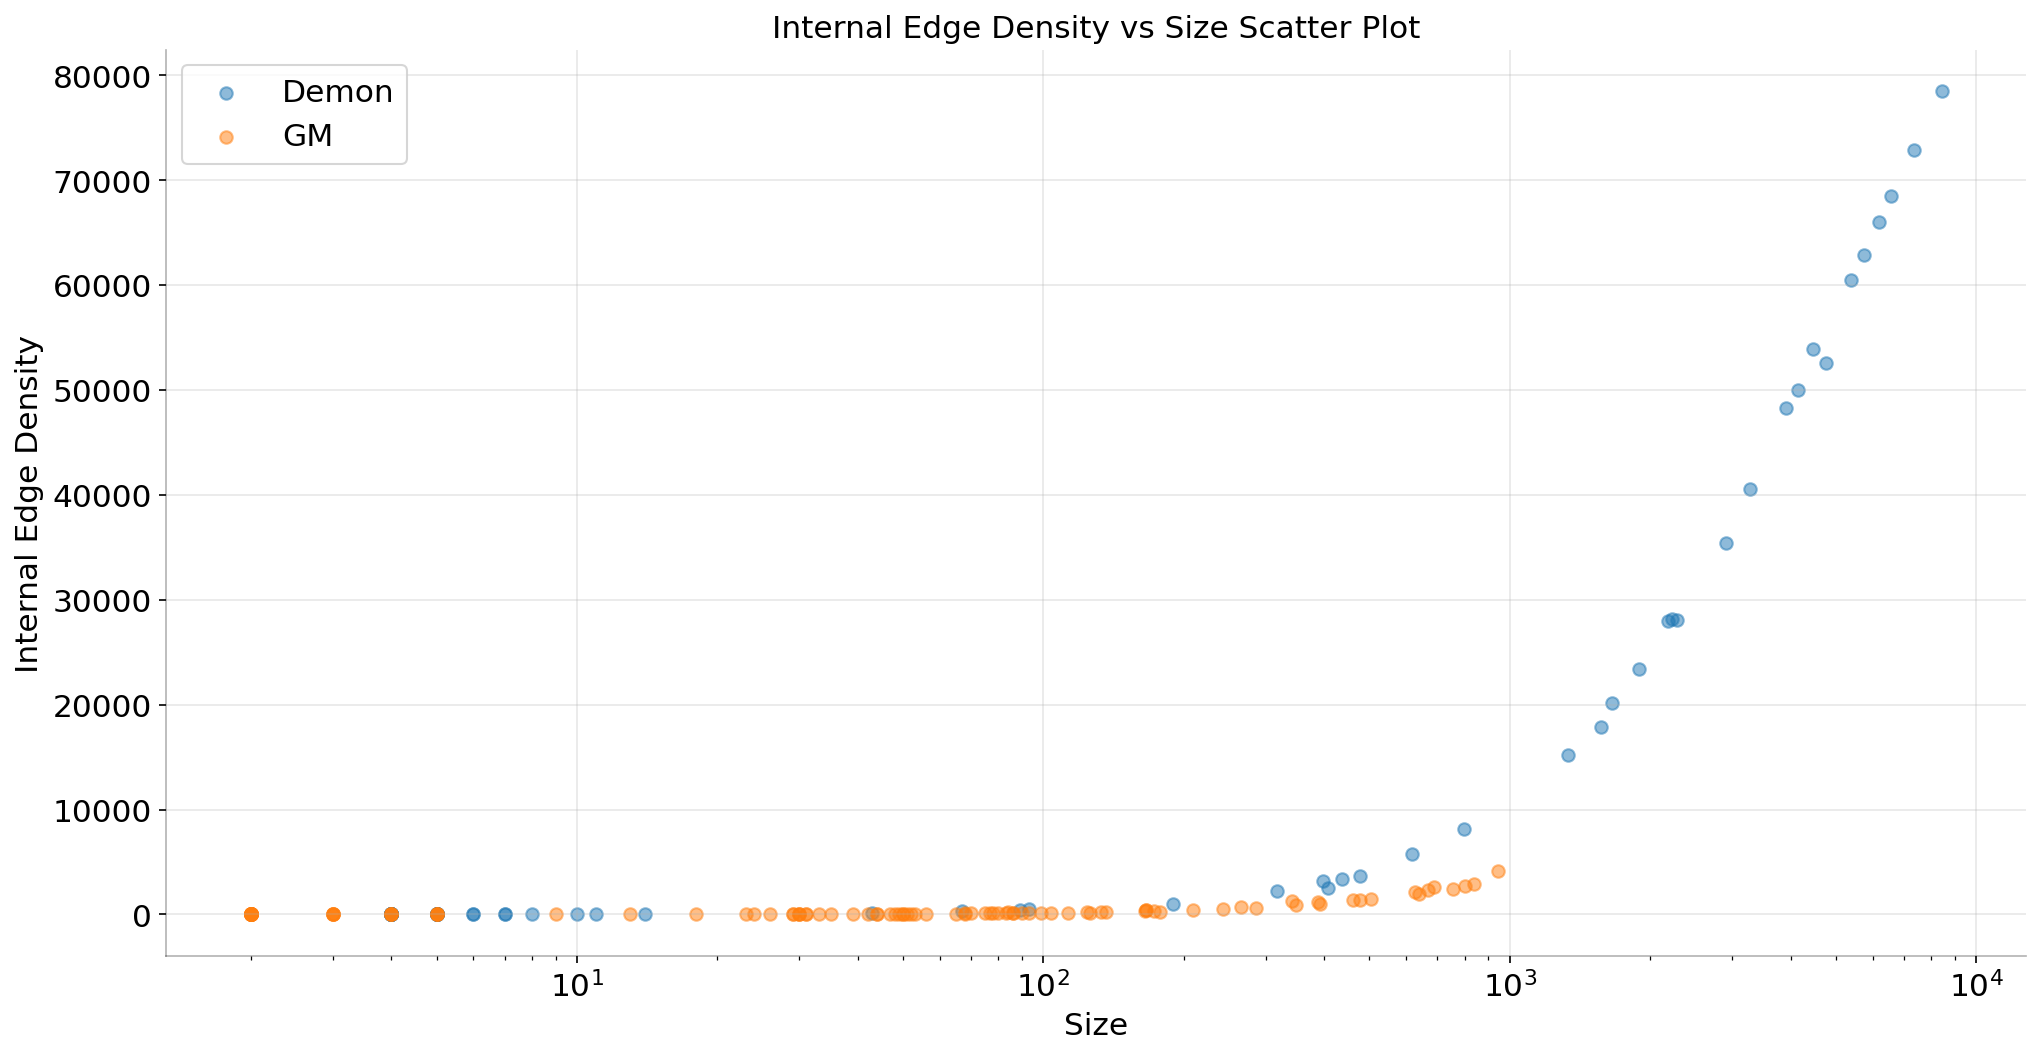

In [71]:
edge_density_= [(np.array(evaluation.size(G,demon_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,demon_coms, summary=False)),
                               "Demon"),
                               (np.array(evaluation.size(G,GM_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,GM_coms, summary=False)),
                                "GM")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

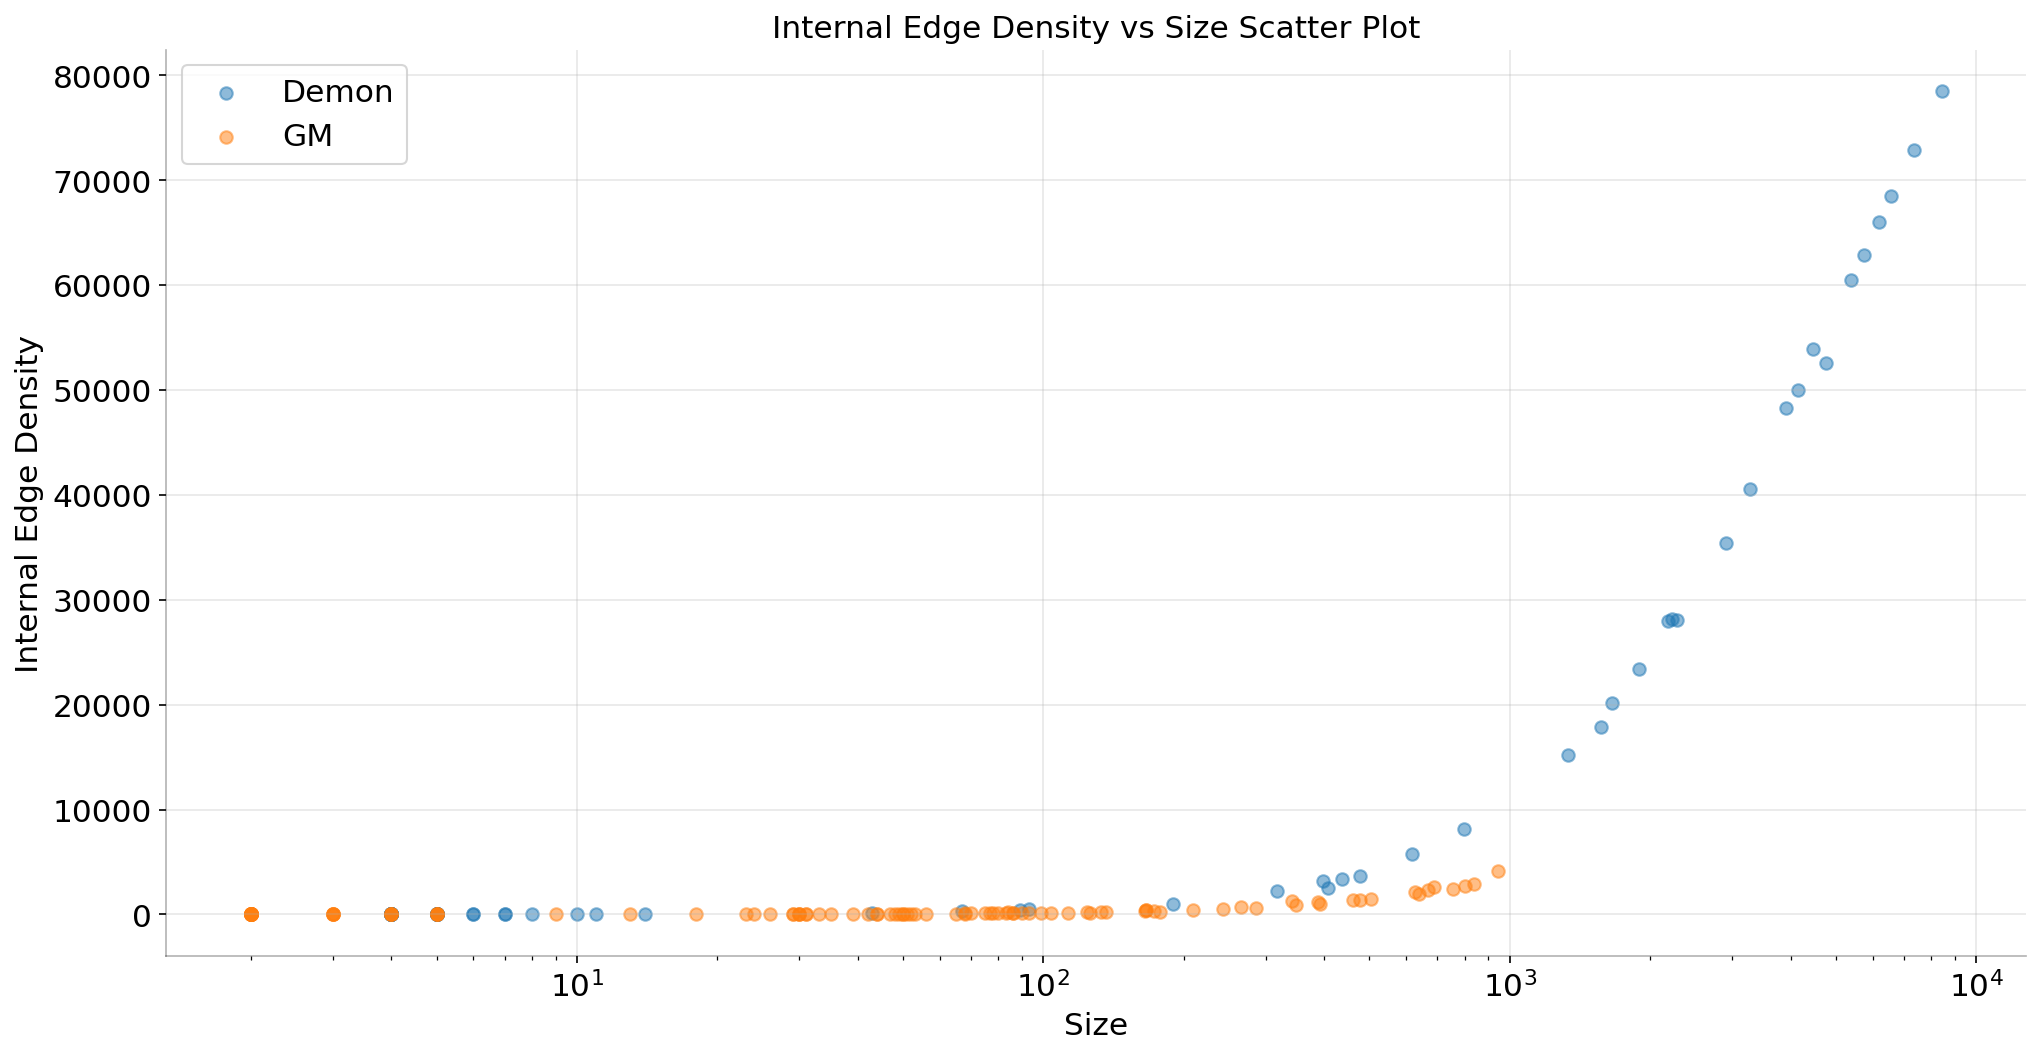

In [72]:
edge_density_= [(np.array(evaluation.size(G,demon_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,demon_coms, summary=False)),
                               "Demon"),
                               (np.array(evaluation.size(G,GM_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,GM_coms, summary=False)),
                                "GM")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

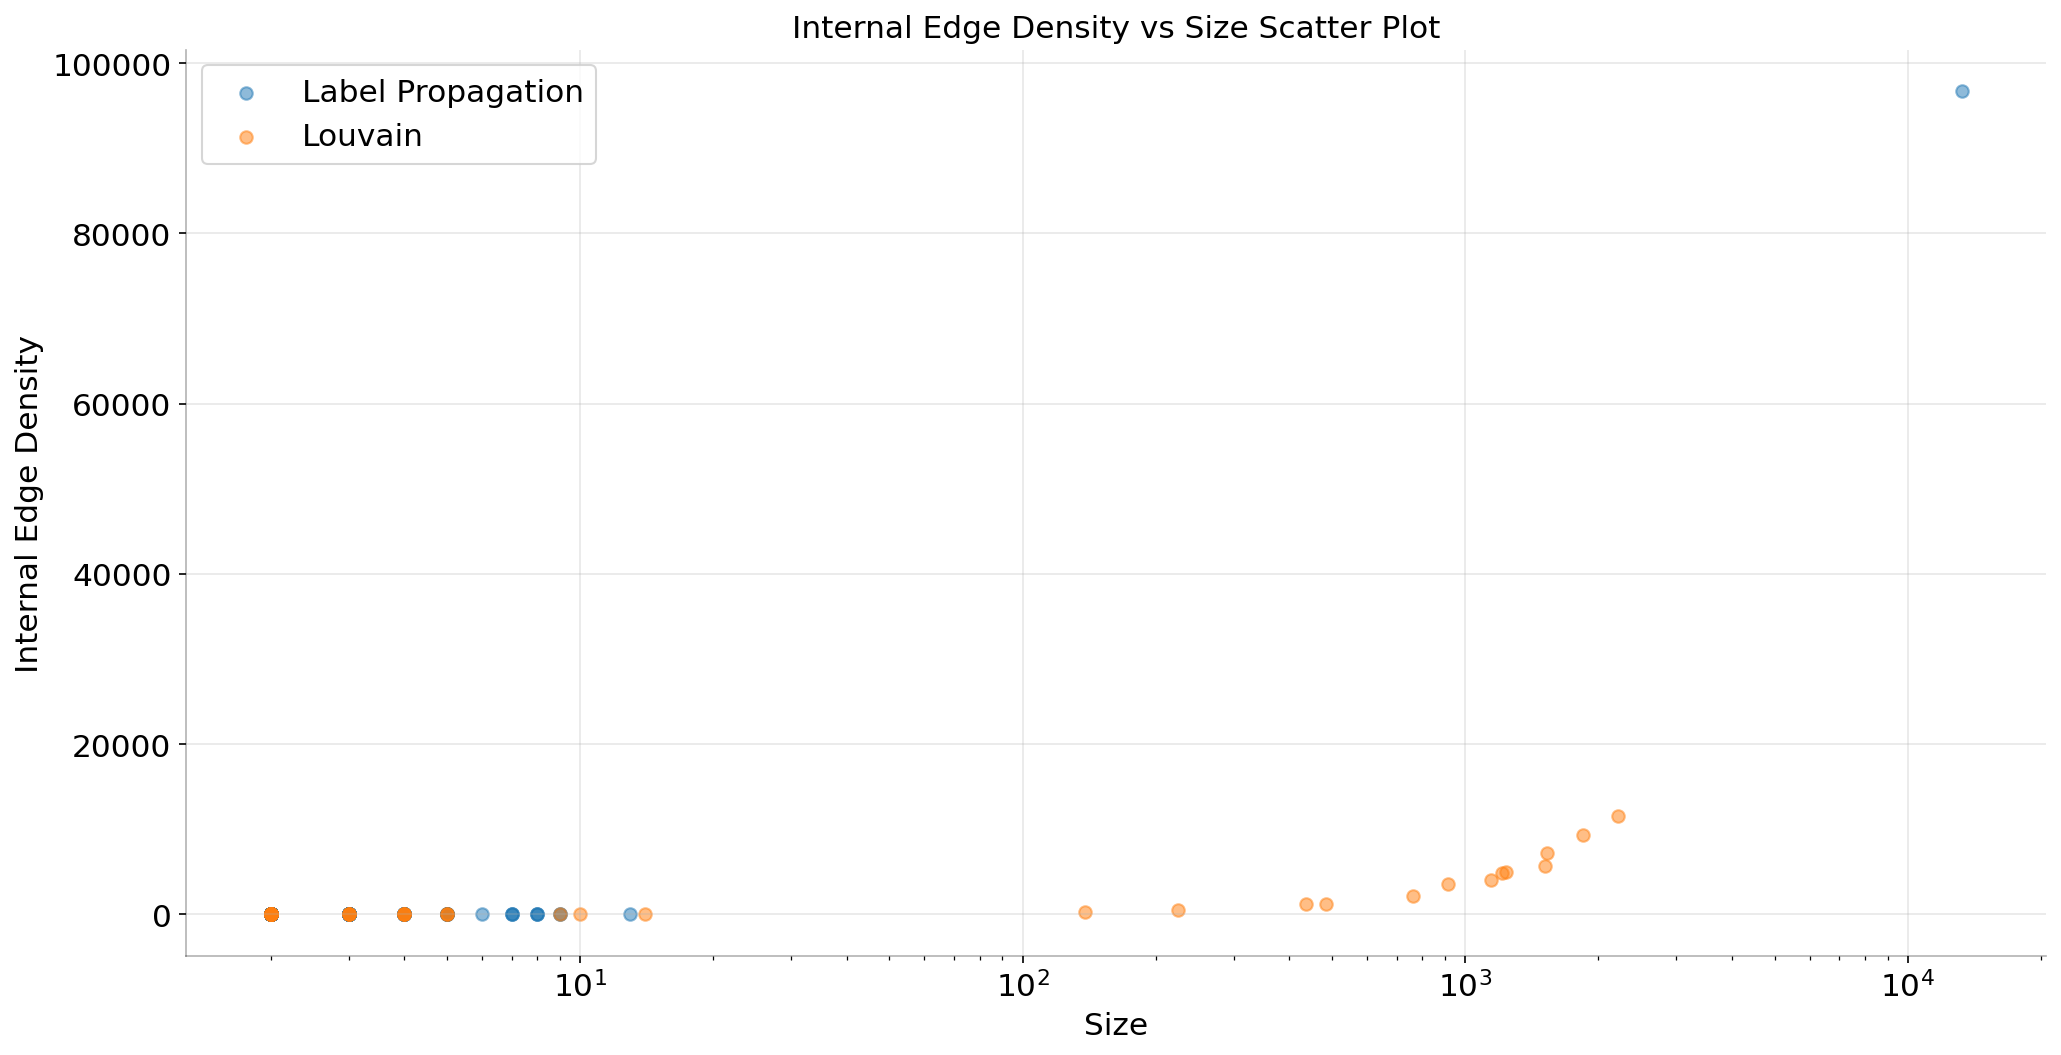

In [73]:
edge_density_ = [(np.array(evaluation.size(G,labelprop_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,labelprop_coms, summary=False)),
                               "Label Propagation"),
                               (np.array(evaluation.size(G,louvain_coms, summary=False)), 
                                np.array(evaluation.edges_inside(G,louvain_coms, summary=False)),
                                "Louvain")]
scatter_plot(edge_density_, "Internal Edge Density vs Size")

In [ ]:
plot_list = [ np.array(evaluation.size(G,louvain_coms, summary=False)), 
             np.array(evaluation.size(G,labelprop_coms, summary=False)),
             np.array(evaluation.size(G,demon_coms, summary=False)),
             np.array(evaluation.size(G,GM_coms, summary=False))]

In [ ]:
(np.array(evaluation.size(G,labelprop_coms, summary=False)), 
                               np.array(evaluation.edges_inside(G,labelprop_coms, summary=False)),

In [74]:
edge_density_all= [(np.array(evaluation.size(G,labelprop_coms, summary=False)), np.array(evaluation.edges_inside(G,labelprop_coms, summary=False)), "Label Propagation"),
                       (np.array(evaluation.size(G,louvain_coms, summary=False)), np.array(evaluation.edges_inside(G,louvain_coms, summary=False)), "Louvain"),
                      (np.array(evaluation.size(G,demon_coms, summary=False)), np.array(evaluation.edges_inside(G,demon_coms, summary=False)), "Demon"),
                       (np.array(evaluation.size(G,GM_coms, summary=False)), np.array(evaluation.edges_inside(G,GM_coms, summary=False)), "GM"),]

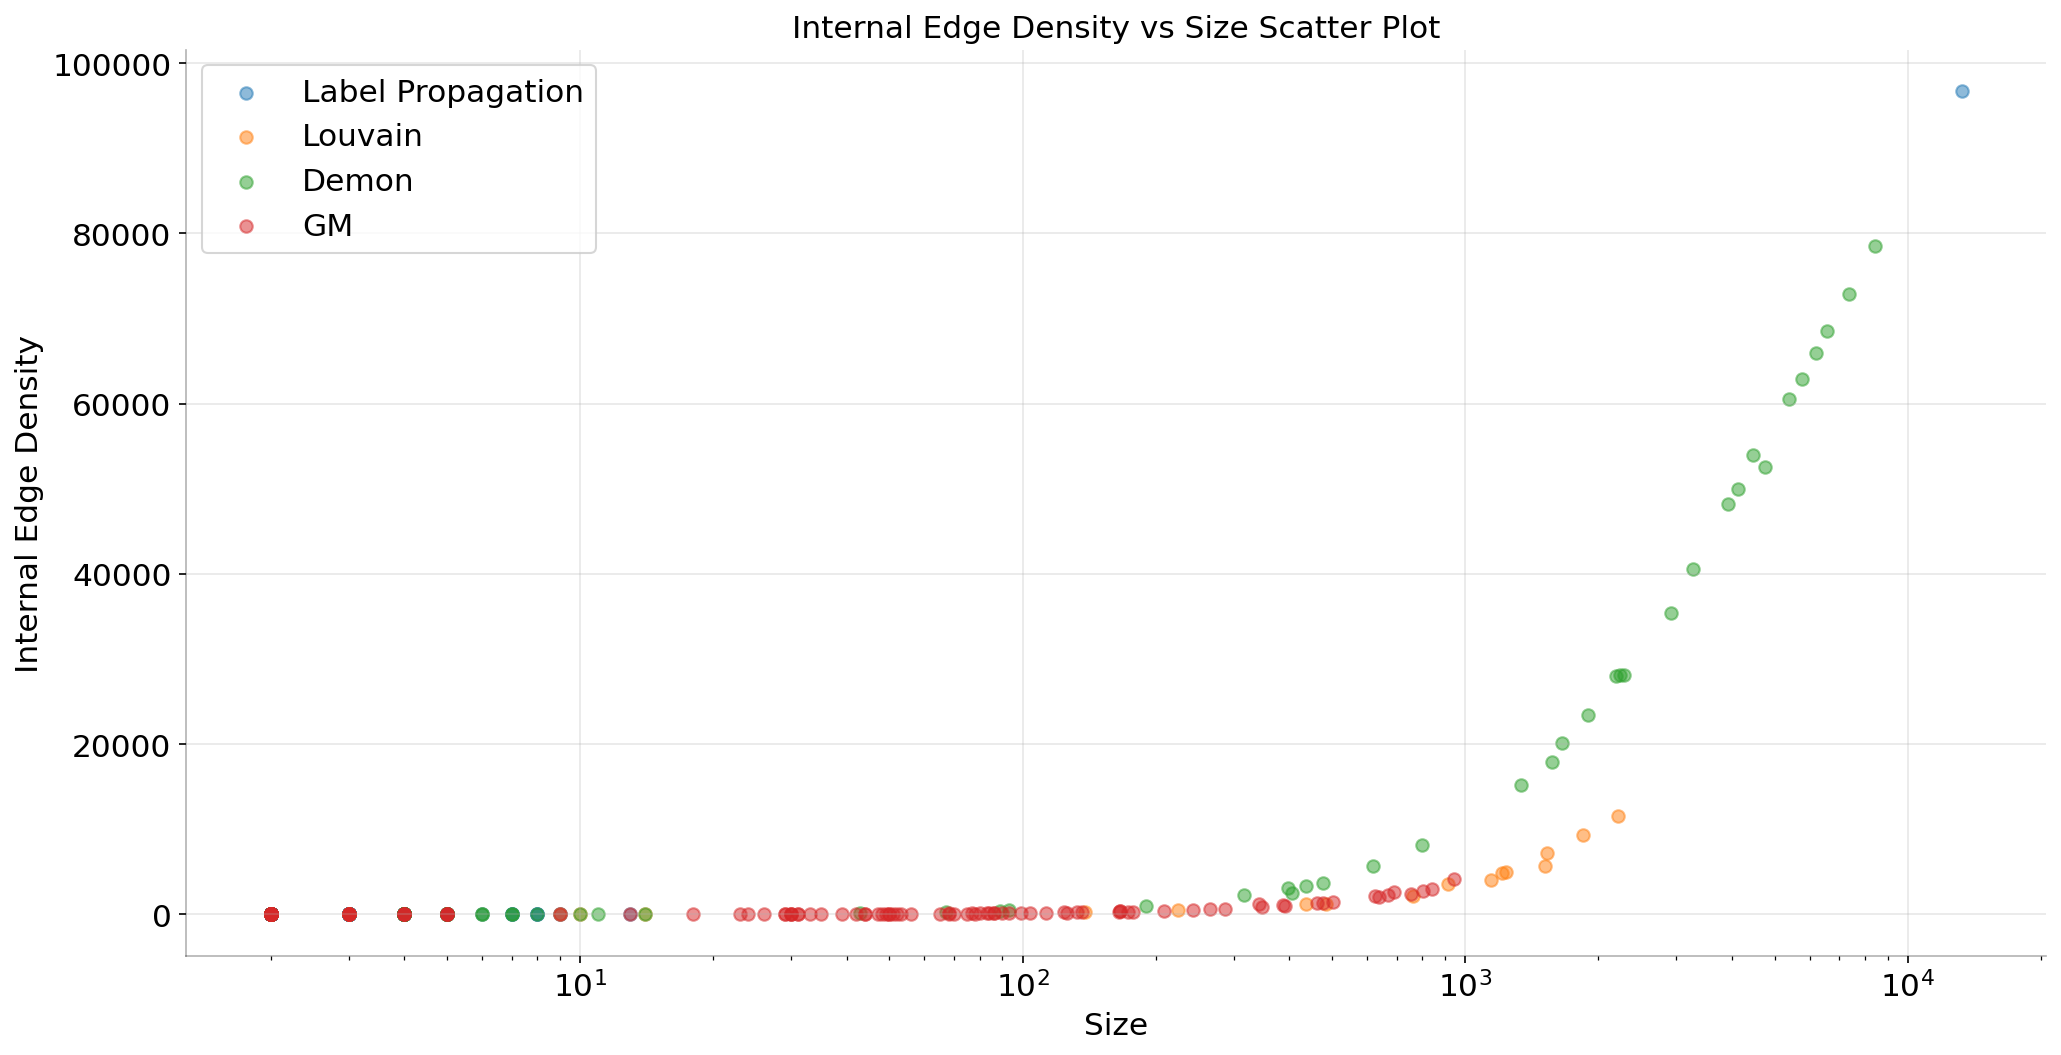

In [75]:
scatter_plot(edge_density_all, "Internal Edge Density vs Size")

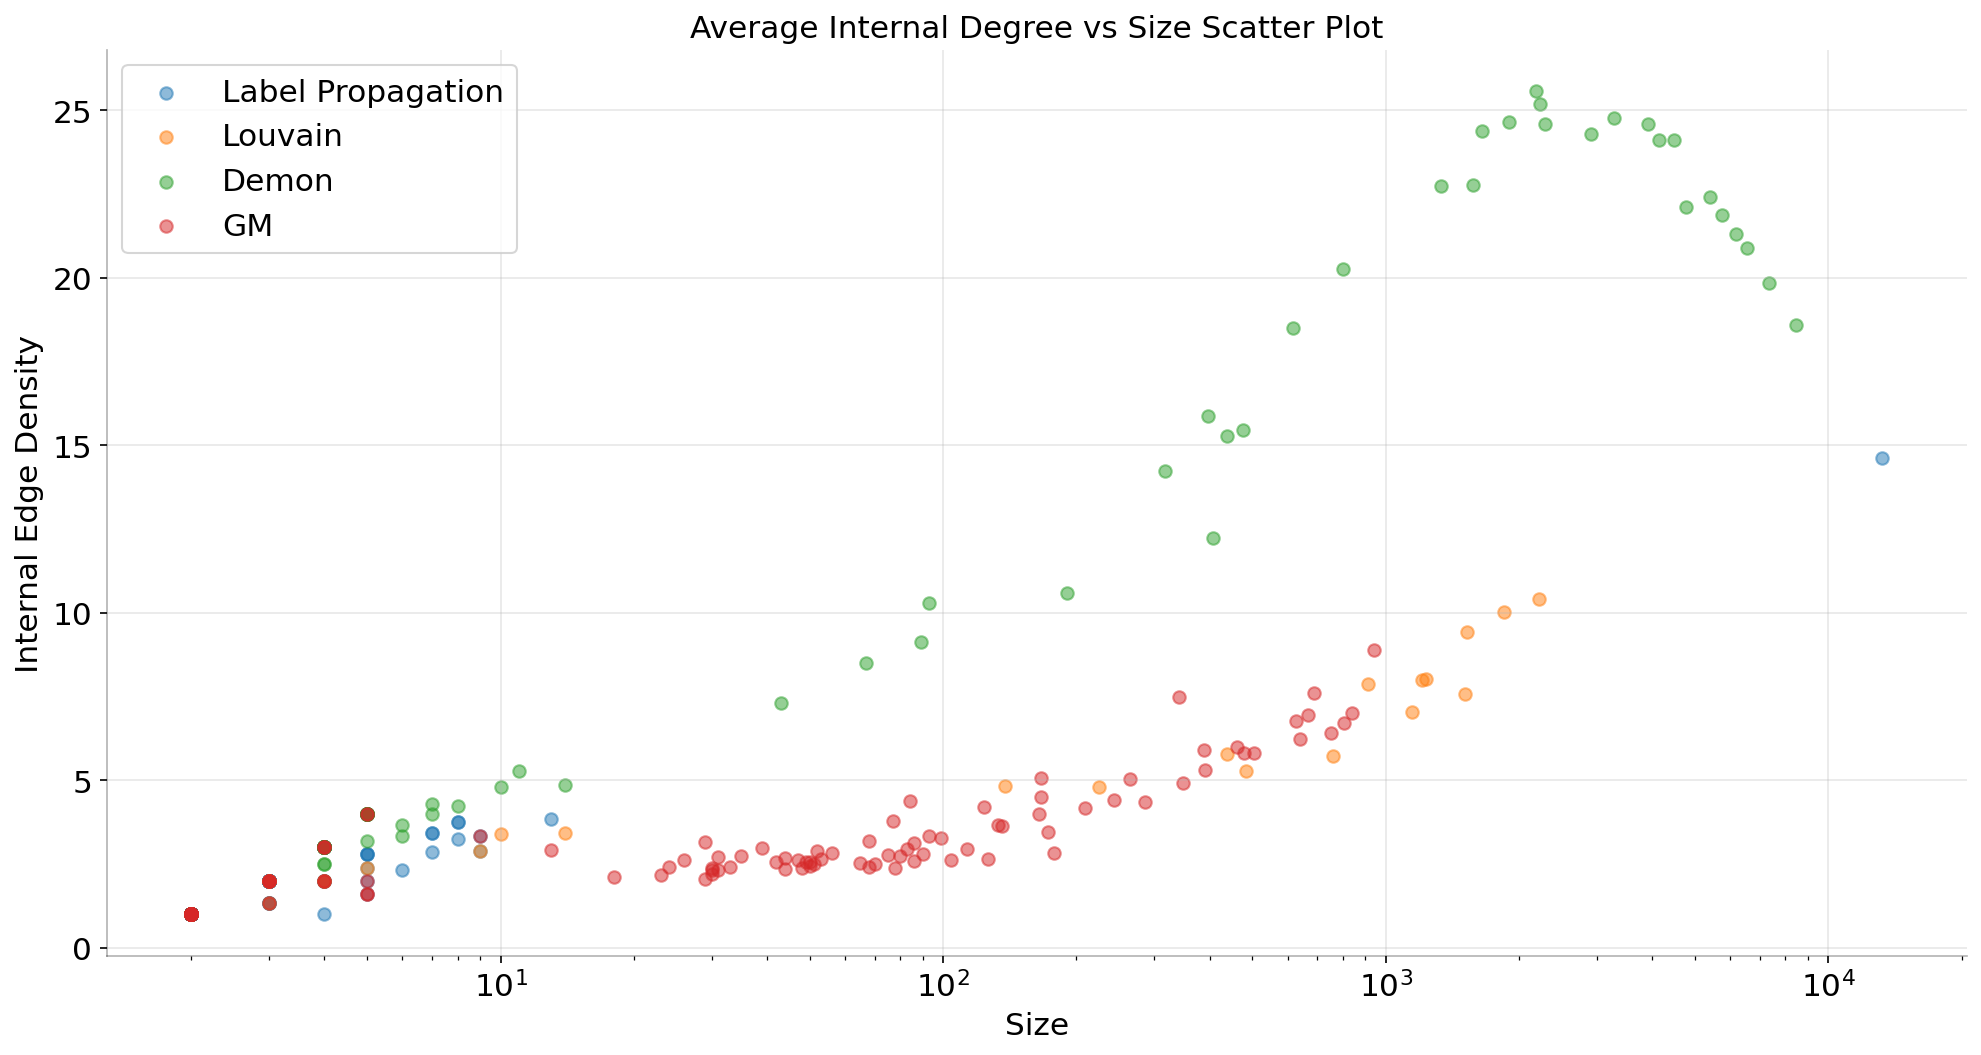

In [76]:
avg_deg_all= [(np.array(evaluation.size(G,labelprop_coms, summary=False)), np.array(evaluation.average_internal_degree(G,labelprop_coms, summary=False)), "Label Propagation"),
                       (np.array(evaluation.size(G,louvain_coms, summary=False)), np.array(evaluation.average_internal_degree(G,louvain_coms, summary=False)), "Louvain"),
                      (np.array(evaluation.size(G,demon_coms, summary=False)), np.array(evaluation.average_internal_degree(G,demon_coms, summary=False)), "Demon"),
                       (np.array(evaluation.size(G,GM_coms, summary=False)), np.array(evaluation.average_internal_degree(G,GM_coms, summary=False)), "GM"),]
scatter_plot(avg_deg_all, "Average Internal Degree vs Size")

3) Comparison NMI, NF1

In [45]:
#Non di Demon (e in caso di Kclique se si riesce a fare) perchè non copre tutto il dataset ed è overlapping
def comparison_NMI(coms1, coms2, name):
    print(f"{name}: ",evaluation.normalized_mutual_information(coms1, coms2))  
    print("********")

In [53]:
def comparison_NF1(coms1, coms2, name):
    print(f"{name}: ",evaluation.nf1(coms1, coms2))
    coms1_tuple = [tuple(x) for x in coms1.communities]
    coms2_tuple = [tuple(x) for x in coms2.communities]
    nf = NF1(coms1_tuple,coms2_tuple)
    results = nf.summary()
    print(results['scores'])
    print(results['details'])
    nf.plot(title=f'{name}')
    print("*********")

NMI

In [46]:
comparison_NMI(louvain_coms, labelprop_coms, "Louvain vs Label")
comparison_NMI(GM_coms, labelprop_coms, "GM vs Label")
comparison_NMI(louvain_coms, GM_coms, "Louvain vs GM")

Louvain vs Label:  MatchingResult(score=0.11128417620683617, std=None)
********
GM vs Label:  MatchingResult(score=0.08952491070518542, std=None)
********
Louvain vs GM:  MatchingResult(score=0.45412820137470494, std=None)
********


NF1

Louvain vs Label Propagation:  MatchingResult(score=0.10551454624402953, std=None)
                               Value
Index                               
Ground Truth Communities  188.000000
Identified Communities     49.000000
Community Ratio             0.260638
Ground Truth Matched        0.191489
Node Coverage               1.000000
NF1                         0.105515
   F1 min  F1 max  F1 mean  F1 mode    F1 std
0     0.0     1.0     0.75      1.0  0.395562


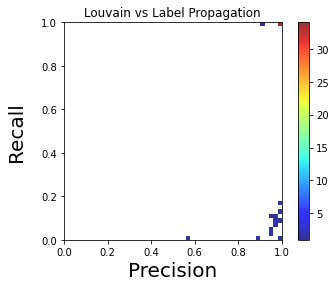

*********
GM vs Label:  MatchingResult(score=0.018403580392843594, std=None)
                               Value
Index                               
Ground Truth Communities  188.000000
Identified Communities    108.000000
Community Ratio             0.574468
Ground Truth Matched        0.180851
Node Coverage               1.000000
NF1                         0.018404
   F1 min  F1 max   F1 mean  F1 mode    F1 std
0     0.0     1.0  0.323241      1.0  0.449707


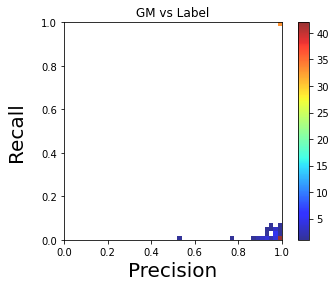

*********
Louvain vs GM:  MatchingResult(score=0.35336387616271003, std=None)
                               Value
Index                               
Ground Truth Communities  108.000000
Identified Communities     49.000000
Community Ratio             0.453704
Ground Truth Matched        0.444444
Node Coverage               1.000000
NF1                         0.353364
   F1 min  F1 max   F1 mean  F1 mode    F1 std
0    0.01     1.0  0.811633      1.0  0.297852


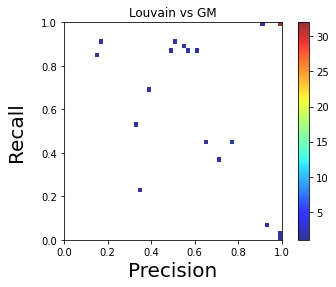

*********
Louvain vs Demon:  MatchingResult(score=0.016418087783058425, std=None)
                              Value
Index                              
Ground Truth Communities  73.000000
Identified Communities    49.000000
Community Ratio            0.671233
Ground Truth Matched       0.178082
Node Coverage              1.064997
NF1                        0.016418
   F1 min  F1 max  F1 mean  F1 mode    F1 std
0     0.0     1.0   0.3475      0.0  0.382745


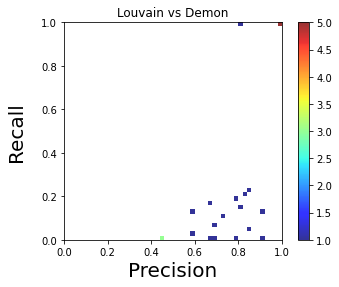

*********
GM vs Demon:  MatchingResult(score=0.002607857030388915, std=None)
                               Value
Index                               
Ground Truth Communities   73.000000
Identified Communities    108.000000
Community Ratio             1.479452
Ground Truth Matched        0.205479
Node Coverage               1.064997
NF1                         0.002608
   F1 min  F1 max   F1 mean  F1 mode    F1 std
0     0.0     1.0  0.091379     0.01  0.229483


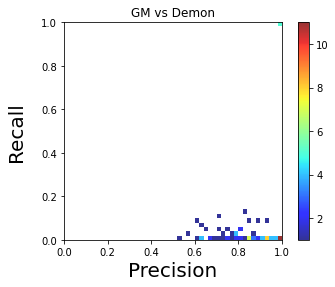

*********
Label Propagation vs Demon:  MatchingResult(score=0.04999299738442846, std=None)
                               Value
Index                               
Ground Truth Communities   73.000000
Identified Communities    188.000000
Community Ratio             2.575342
Ground Truth Matched        0.821918
Node Coverage               1.064997
NF1                         0.049993
   F1 min  F1 max   F1 mean  F1 mode    F1 std
0     0.0     1.0  0.190584      0.0  0.356098


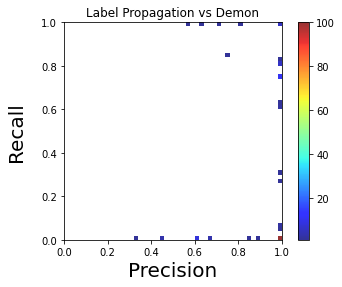

*********


In [56]:
comparison_NF1(louvain_coms, labelprop_coms, "Louvain vs Label Propagation")
comparison_NF1(GM_coms, labelprop_coms, "GM vs Label")
comparison_NF1(louvain_coms, GM_coms, "Louvain vs GM")

comparison_NF1(louvain_coms, demon_coms, "Louvain vs Demon")
comparison_NF1(GM_coms, demon_coms, "GM vs Demon")
comparison_NF1(labelprop_coms, demon_coms, "Label Propagation vs Demon")

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

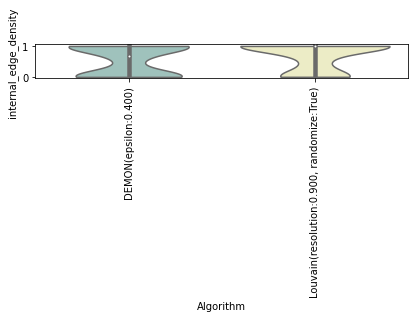

In [19]:
viz.plot_com_stat([demon_coms, louvain_coms], evaluation.internal_edge_density)

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

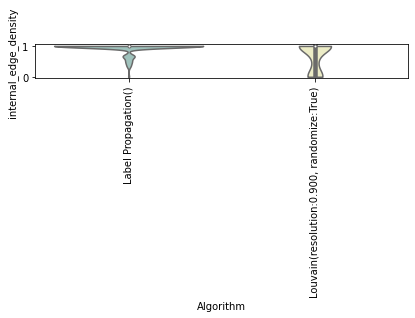

In [20]:
viz.plot_com_stat([labelprop_coms, louvain_coms], evaluation.internal_edge_density)

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

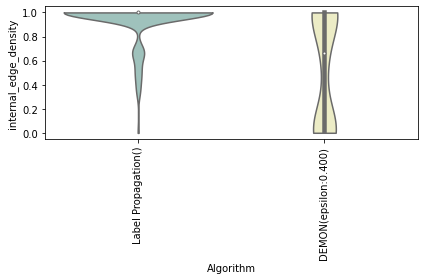

In [21]:
viz.plot_com_stat([labelprop_coms, demon_coms], evaluation.internal_edge_density)

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

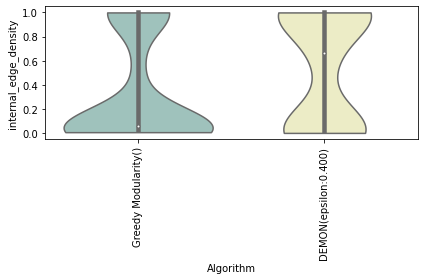

In [22]:
viz.plot_com_stat([GM_coms, demon_coms], evaluation.internal_edge_density)

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

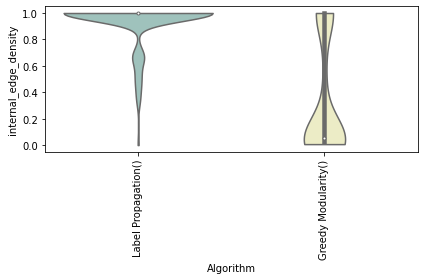

In [23]:
viz.plot_com_stat([labelprop_coms, GM_coms], evaluation.internal_edge_density)

c:\users\matte\.conda\envs\ambiente_con_librerie\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Algorithm', ylabel='internal_edge_density'>

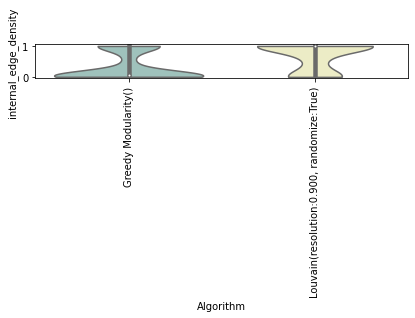

In [24]:
viz.plot_com_stat([GM_coms, louvain_coms], evaluation.internal_edge_density)

# 6 - Prova Kcliques

In [107]:
import random
k = 8500
sampled_nodes = random.sample(G.nodes, k)
sampled_graph = G.subgraph(sampled_nodes)
k_num = ensemble.Parameter(name="k", start=2, end=8, step=1)

k_coms, scoring = ensemble.random_search(graph=sampled_graph, method=algorithms.kclique,
                                                       parameters=[k_num],
                                                       quality_score=evaluation.newman_girvan_modularity,
                                                       instances=3, aggregate=max)

In [25]:
with open(community_path+'k.pickle', 'wb') as f:
    pickle.dump(k_coms, f)

In [108]:
with open(community_path+'k.pickle', 'rb') as f:
    k_coms = pickle.load(f)

In [113]:
print(print_bold_str("Average Internal Degree:"), k_coms.average_internal_degree())
print(print_bold_str("Internal Edge Density:"), k_coms.internal_edge_density())
print(print_bold_str("Conductance:"), k_coms.conductance())
print(print_bold_str("Erdos Renyi Modularity:"), k_coms.erdos_renyi_modularity())
print(print_bold_str("Newman Girvan Modularity:"), k_coms.newman_girvan_modularity())
print(print_bold_str("Modularity Density:"), k_coms.modularity_density())
print(print_bold_str("Z Modularity:"), k_coms.z_modularity())

Average Internal Degree: FitnessResult(min=2.0, max=11.4933464760966, score=2.155272558232649, std=0.6181026243683844)
Internal Edge Density: FitnessResult(min=0.0018884893979784093, max=1.0, score=0.987785378410407, std=0.07539800942839067)
Conductance: FitnessResult(min=0.0, max=0.9958333333333333, score=0.7474652192717908, std=0.24774550901588177)
Erdos Renyi Modularity: FitnessResult(min=None, max=None, score=0.4496784245742114, std=None)
Newman Girvan Modularity: FitnessResult(min=None, max=None, score=-0.012348053530396655, std=None)
Modularity Density: FitnessResult(min=None, max=None, score=-12580.719917740387, std=None)
Z Modularity: FitnessResult(min=None, max=None, score=0.1399645952692478, std=None)


In [114]:
print(print_bold_str("N_Community:"), len(k_coms.communities))

max_com_len = 0
for com in k_coms.communities:
    if len(com) > max_com_len:
        max_com_len = len(com)
print(print_bold_str("Max_Dim_Community:"), max_com_len)   

N_Community: 332
Max_Dim_Community: 6087


In [115]:
k_tuple = [tuple(x) for x in k_coms.communities]

{'6087': 1, '8': 1, '7': 2, '5': 6, '4': 32, '3': 290}


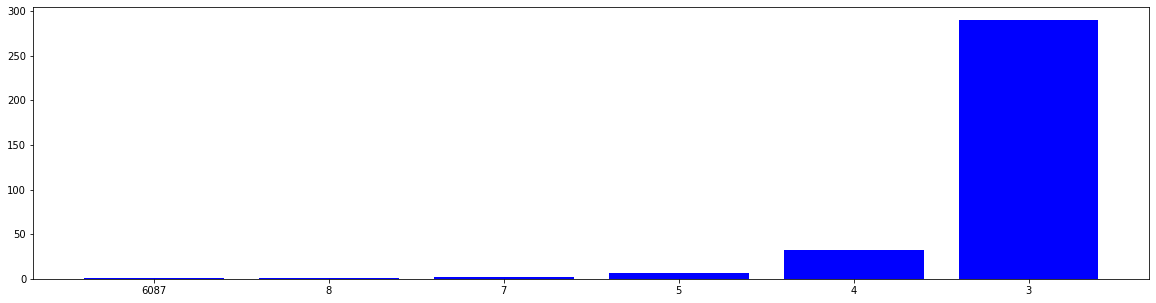

In [116]:
plot_communities_dimentions(k_tuple)

In [120]:
covg_overlap(sampled_graph, k_coms, "K-Cliques")

K-Cliques coverage: 0.7831764705882353
K-Cliques overlap: True
K-Cliques avg degree: FitnessResult(min=0.0, max=6.705411890162623, score=0.9741987449359458, std=0.8603002243522321)
*******


# 7 - Analisi delle communities di Louvain

1) Prova edit distance con supervisione tag

In [6]:
from collections import Counter
from wordcloud import WordCloud

In [7]:
saved_path2 = "../DataSet StackOverflow/nodes_tagged_by_language.csv"

In [8]:
tagged_dg = pd.read_csv(saved_path2)

In [9]:
s_tag = tagged_dg[tagged_dg["Named"]!="unamed"][["Id", "Named"]]
s_tag

Id                      Named
0             python      Python & R Developers
1         javascript  Android & Java Developers
2               java  Android & Java Developers
3            android  Android & Java Developers
4                c++               C Developers
...              ...                        ...
13728  github-api-v3            Version Control
13736        opensql        Database Developers
13740       javacard  Android & Java Developers
13750     feathersjs        FrontEnd Developers
13757        maven-2  Android & Java Developers

[2405 rows x 2 columns]

In [10]:
def edit_distance(s1, s2):
    m=len(s1)+1
    n=len(s2)+1

    tbl = {}
    for i in range(m): tbl[i,0]=i
    for j in range(n): tbl[0,j]=j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            tbl[i,j] = min(tbl[i, j-1]+1, tbl[i-1, j]+1, tbl[i-1, j-1]+cost)

    return tbl[i,j]

In [57]:
dd = {}

In [64]:
categories_list = []
for s in louvain_coms.communities[1]:
    category = ""
    maxmax_ = 30
    for n in set(s_tag["Named"]):
        to_check = list(s_tag[s_tag["Named"]==n]["Id"])
        max_ = 30
        for ss in to_check:
            edit = edit_distance(s, ss)
            if  edit < max_:
                max_ = edit
        if max_ < maxmax_:
            maxmax_ = max_
            category = n
    categories_list.append(category)

In [65]:
new_new_df = pd.DataFrame({"Com_1": categories_list})
new_new_df.to_csv(community_path + "Com_1.csv", index=False)

In [66]:
dd[1]=categories_list

In [67]:
dd[1]

['Android & Java Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Database Developers',
 'Python & R Developers',
 'C Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Apple Developers',
 'Database Developers',
 'Python & R Developers',
 'C Developers',
 'Python & R Developers',
 'C Developers',
 'FrontEnd Developers',
 'Python & R Developers',
 'Apple Developers',
 'Version Control',
 'Android & Java Developers',
 'Android & Java Developers',
 'Android & Java Developers',
 'C Developers',
 'C Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Python & R Developers',
 'FrontEnd Developers',
 'Apple Developers',
 'Python & R Developers',
 'FrontEnd Developers',
 'Apple Developers',
 'FrontEnd Developers',
 'FrontEnd Developers',
 'FrontEnd Developers',
 'FrontEnd Developers',
 'Python & R Developers',
 'Python & R Developers',
 'Version Control',
 'Python & R 

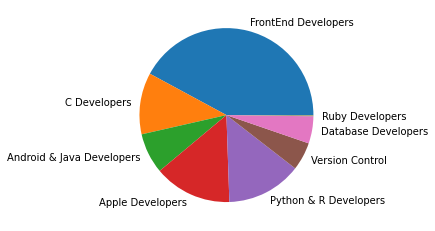

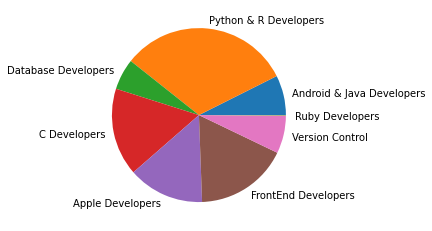

In [68]:
import matplotlib.pyplot as pyplot

for i in range(2):
    all_string = ""
    for s in dd[i]:
        all_string = all_string + s + "_"
    word_could_dict=Counter(all_string.split("_"))
    pyplot.pie([float(v) for v in word_could_dict.values()], labels=[k for k in word_could_dict],
           autopct=None)
    pyplot.show()

2) Prova word cloud

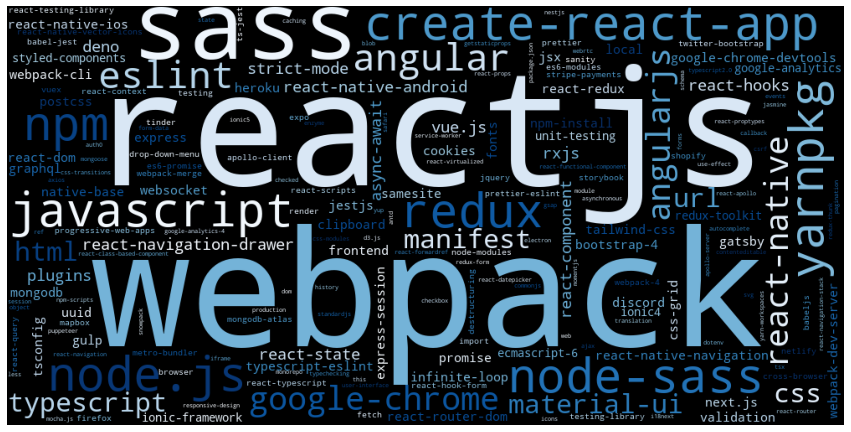

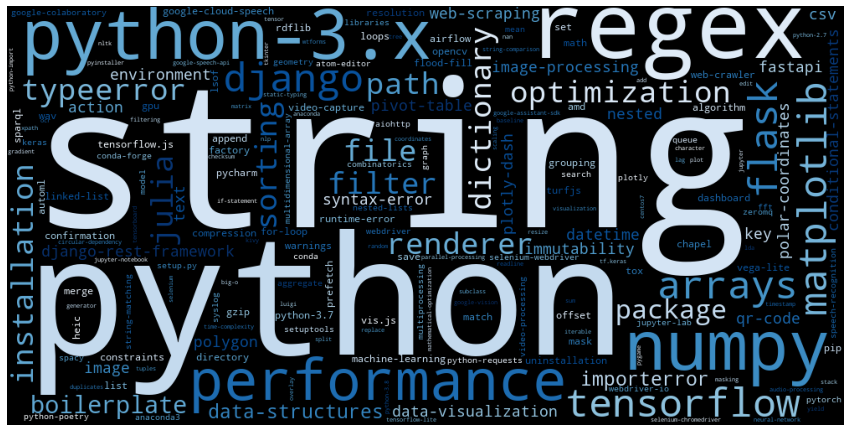

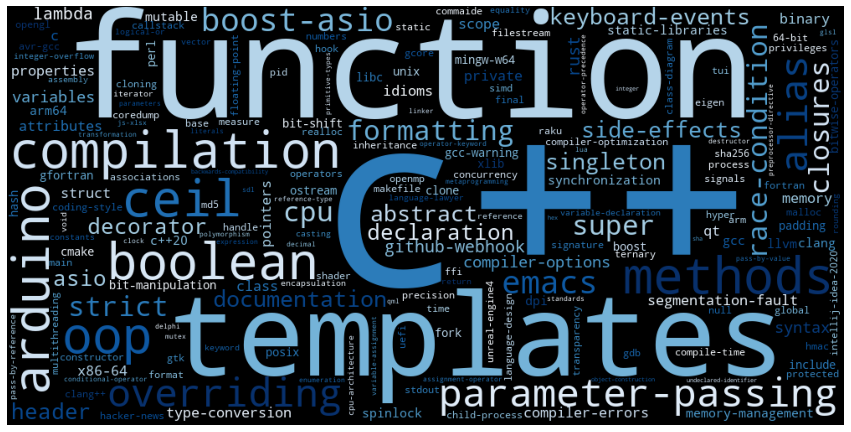

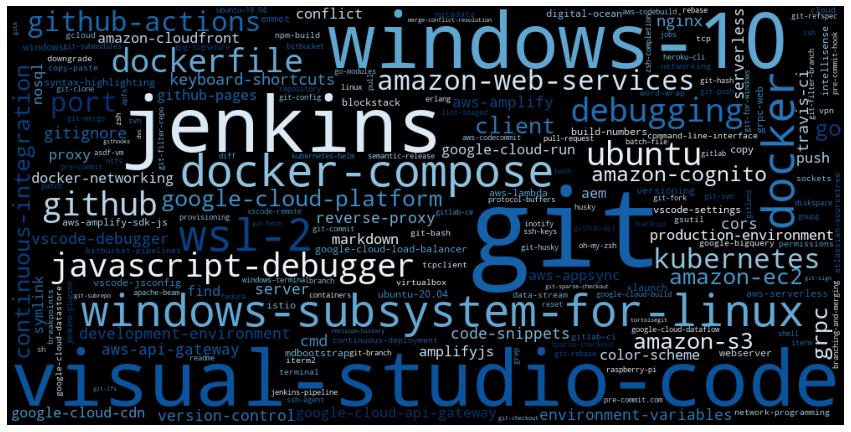

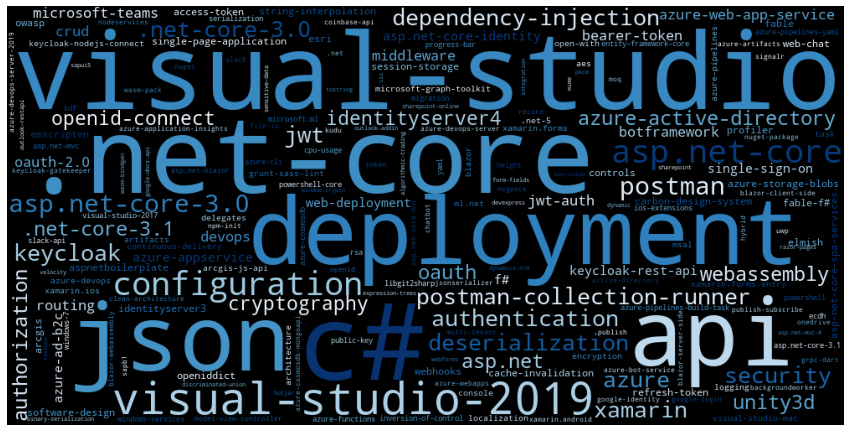

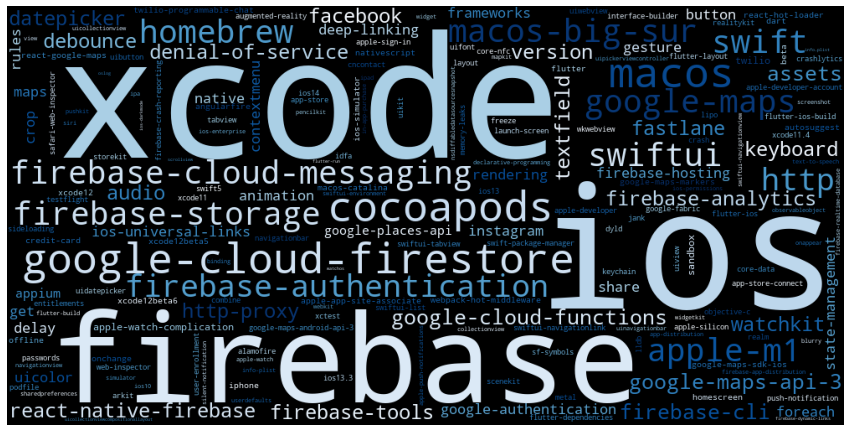

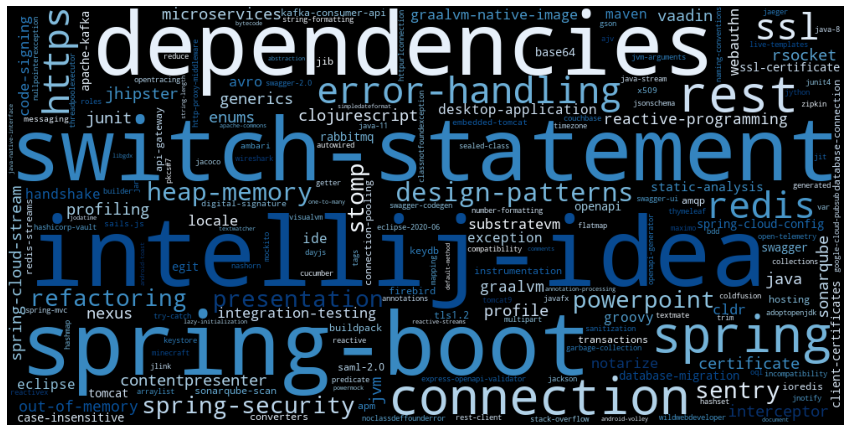

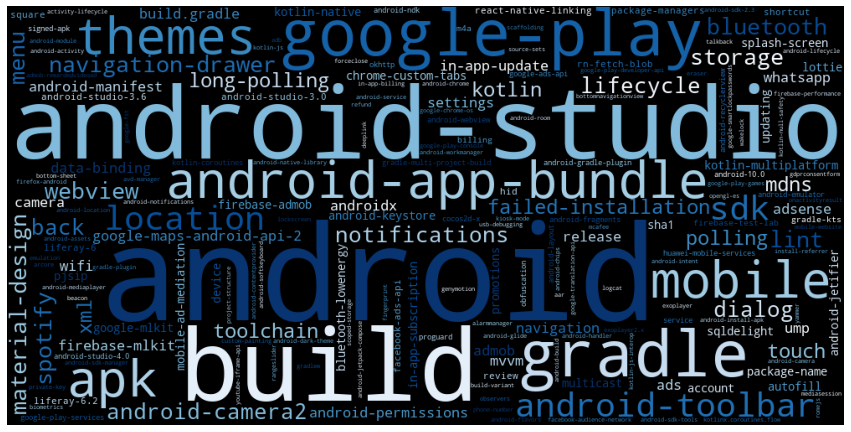

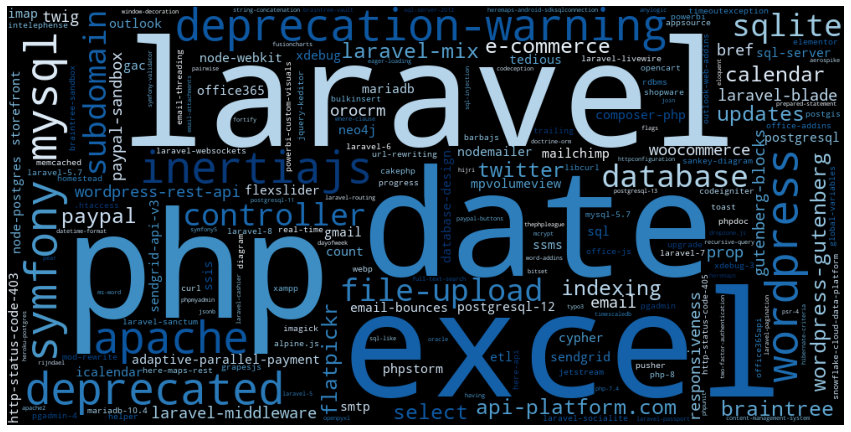

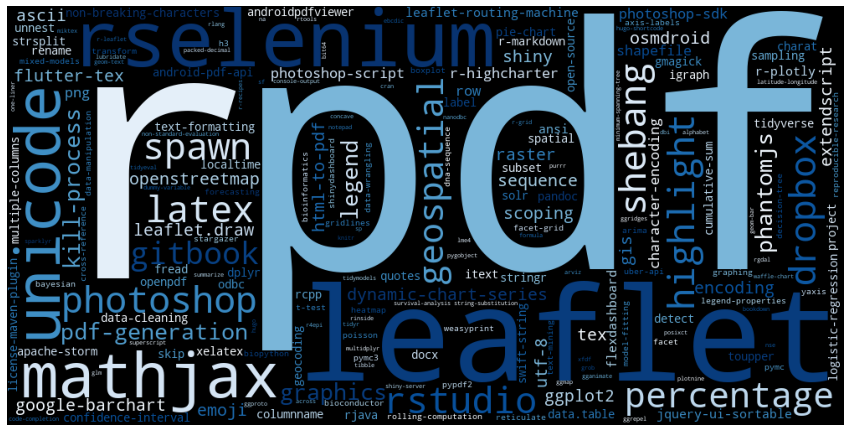

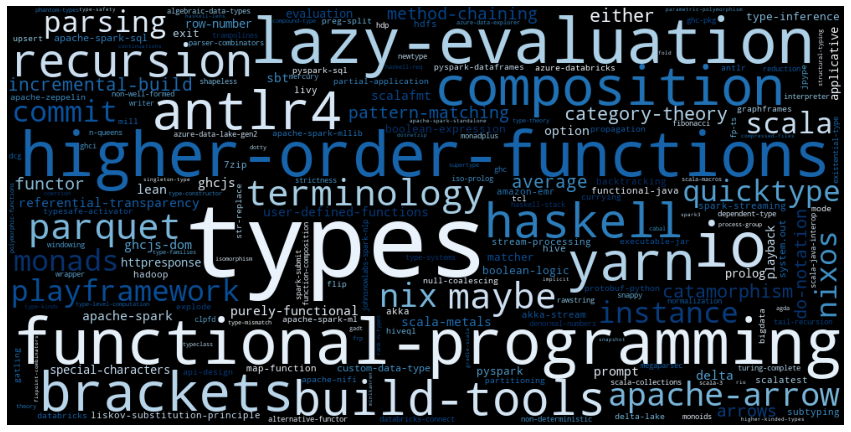

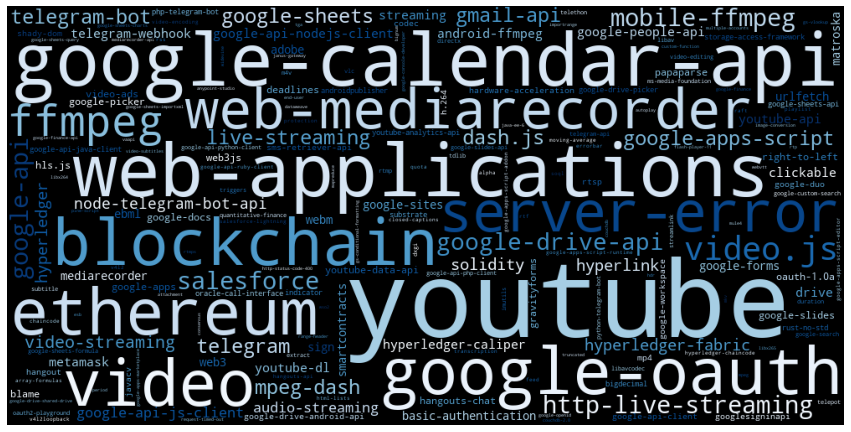

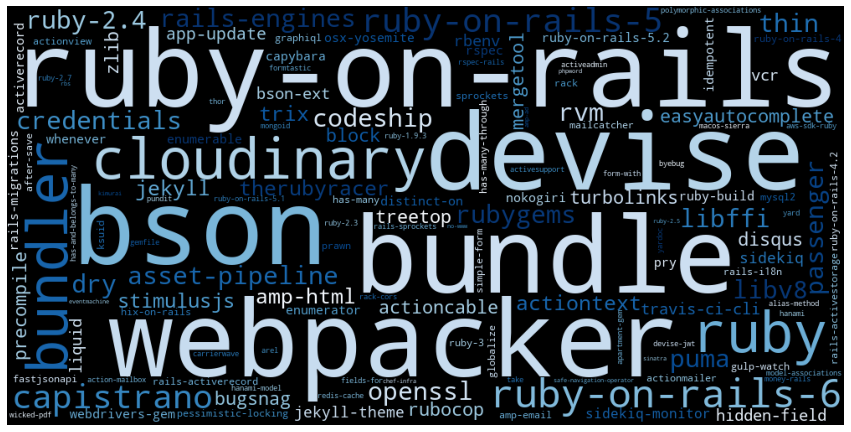

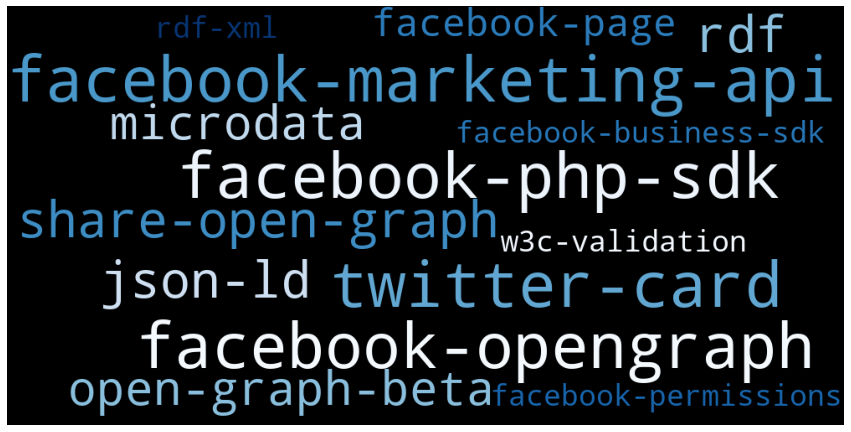

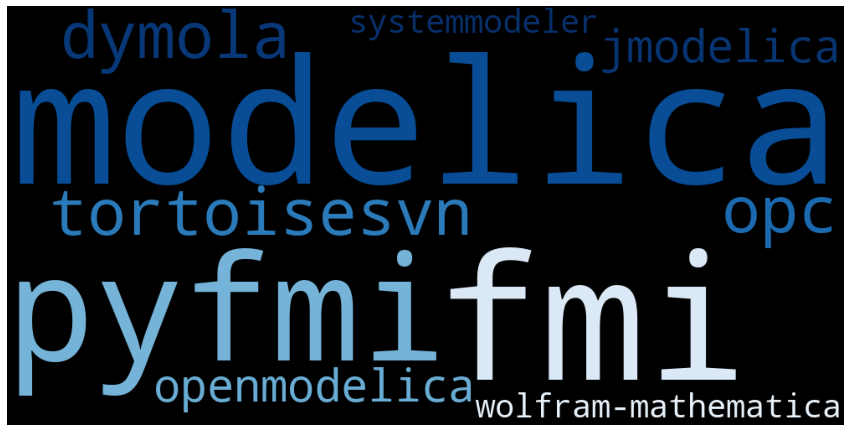

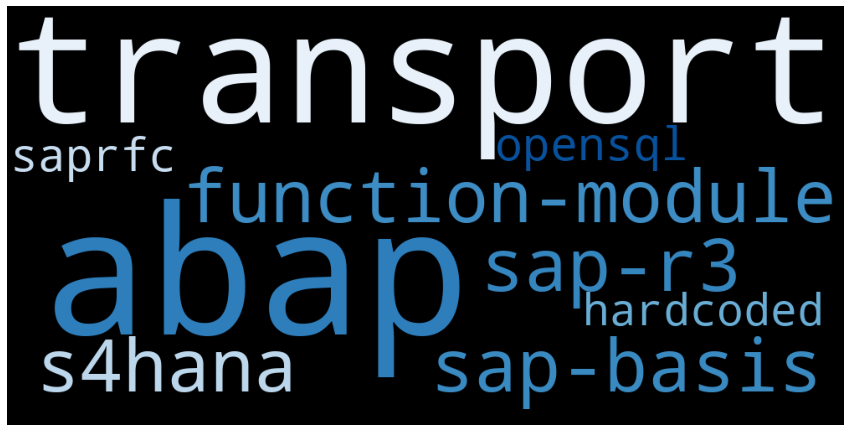

In [103]:
for i in louvain_coms.communities[:16]:
    all_string = ""
    for s in i:
        all_string = all_string + s + " "
    word_could_dict=Counter(all_string.split())
    wordcloud = WordCloud(width = 1000, height = 500 , colormap="Blues").generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
#0: react, node, frontend
#1: python, julia, learning
#2: C development
#3: version control
#4: deployment

# Analisi delle community Demon

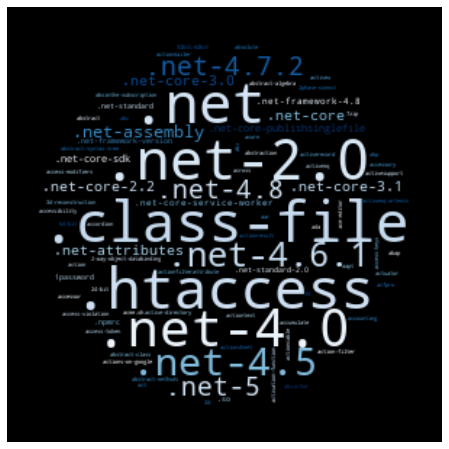

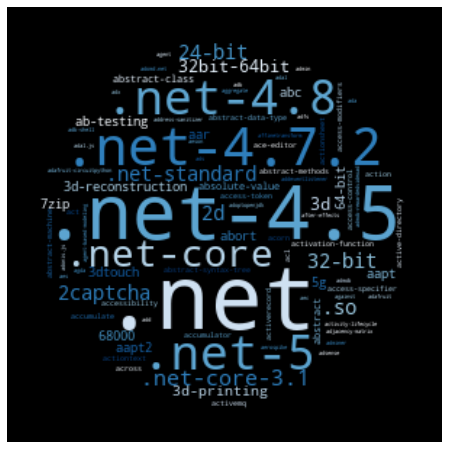

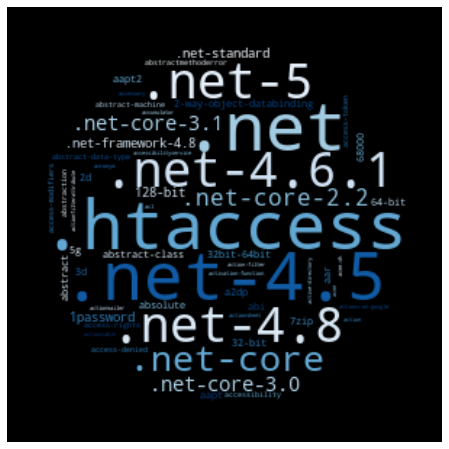

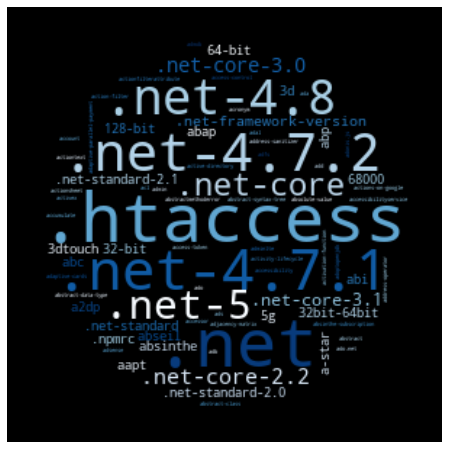

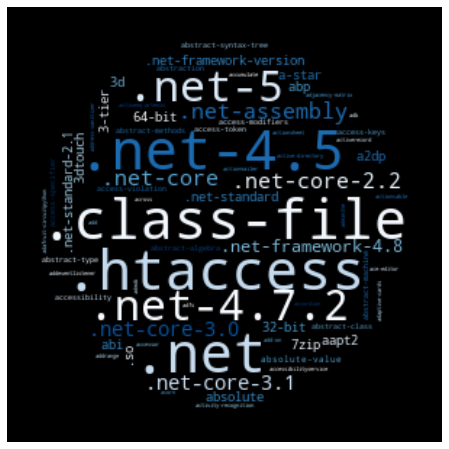

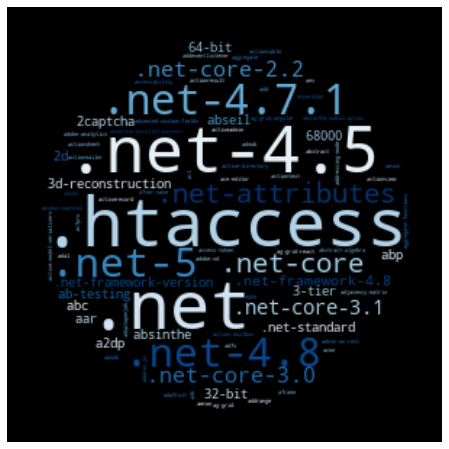

In [10]:
for i in demon_coms.communities[:6]:
    all_string = ""
    for s in i:
        all_string = all_string + s + " "
    
    word_could_dict=Counter(all_string.split())
    """
    wordcloud = WordCloud(width = 1000, height = 500 , colormap="Blues").generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()
    """
    
    # makes the circle using numpy
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)

    # Generate a word cloud of document
    wordcloud = WordCloud(mask=mask, contour_width=0.1, colormap="Blues").generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(15,8))
    #Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()